# IRONHACK Final Project - Airline Churn Rate

### Libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib as mpl
import scipy.stats as st
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
from sklearn.feature_selection import SelectKBest, f_classif, chi2

from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans
from kmodes.kmodes import KModes
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import auc, roc_auc_score, roc_curve

sns.set()
%matplotlib inline

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=20)   # fontsize of the figure title

### Data Acquisition

In [2]:
aps=pd.read_csv('../Desktop/Airline_Passenger_Satisfaction_26K.csv')
pd.options.display.max_columns=25

In [3]:
aps.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,3,4,3,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0,6.0,satisfied
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0,20.0,satisfied


In [4]:
aps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25976 entries, 0 to 25975
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         25976 non-null  int64  
 1   id                                 25976 non-null  int64  
 2   Gender                             25976 non-null  object 
 3   Customer Type                      25976 non-null  object 
 4   Age                                25976 non-null  int64  
 5   Type of Travel                     25976 non-null  object 
 6   Class                              25976 non-null  object 
 7   Flight Distance                    25976 non-null  int64  
 8   Inflight wifi service              25976 non-null  int64  
 9   Departure/Arrival time convenient  25976 non-null  int64  
 10  Ease of Online booking             25976 non-null  int64  
 11  Gate location                      25976 non-null  int

### Data Cleaning

#### Renaming Columns

In [5]:
aps.rename(columns={'Customer Type':'Customer_Type', 
                    'Type of Travel':'Travel_Type', 
                    'Flight Distance':'Flight_Distance',
                    'Inflight wifi service':'Inflight_Wifi',
                    'Departure/Arrival time convenient':'Departure_Arrival_Time_Convenience',
                    'Ease of Online booking':'Ease_of_Online_Booking',
                    'Gate location':'Gate_Location', 
                    'Food and drink':'Food_Drink',
                    'Online boarding':'Online_Boarding',
                    'Seat comfort':'Seat_Comfort',
                    'Inflight entertainment':'Inflight_Entertainment',
                    'On-board service':'On-board_Service',
                    'Leg room service':'Seat_Pitch',
                    'Baggage handling':'Baggage_Handling',
                    'Checkin service':'Checkin_Service',
                    'Inflight service':'Inflight_Service',
                    'Departure Delay in Minutes':'Departure_Delay_min',
                    'Arrival Delay in Minutes':'Arrival_Delay_min',
                    'satisfaction':'Churn'}, inplace=True)

In [6]:
aps.Customer_Type=aps.Customer_Type.replace('disloyal Customer','Disloyal Customer')

In [7]:
aps.Travel_Type=aps.Travel_Type.replace('Business travel','Business Travel')

In [8]:
aps.Churn=aps.Churn.replace('neutral or dissatisfied','Unsatisfied').replace('satisfied','Satisfied')

In [9]:
aps

,Unnamed: 0,id,Gender,Customer_Type,Age,Travel_Type,Class,Flight_Distance,Inflight_Wifi,Departure_Arrival_Time_Convenience,Ease_of_Online_Booking,Gate_Location,Food_Drink,Online_Boarding,Seat_Comfort,Inflight_Entertainment,On-board_Service,Seat_Pitch,Baggage_Handling,Checkin_Service,Inflight_Service,Cleanliness,Departure_Delay_min,Arrival_Delay_min,Churn
0,0,19556,Female,Loyal Customer,52,Business Travel,Eco,160,5,4,3,4,3,4,3,5,5,5,5,2,5,5,50,44.0,Satisfied
1,1,90035,Female,Loyal Customer,36,Business Travel,Business,2863,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0,0.0,Satisfied
2,2,12360,Male,Disloyal Customer,20,Business Travel,Eco,192,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0,0.0,Unsatisfied
3,3,77959,Male,Loyal Customer,44,Business Travel,Business,3377,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0,6.0,Satisfied
4,4,36875,Female,Loyal Customer,49,Business Travel,Eco,1182,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0,20.0,Satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25971,25971,78463,Male,Disloyal Customer,34,Business Travel,Business,526,3,3,3,1,4,3,4,4,3,2,4,4,5,4,0,0.0,Unsatisfied
25972,25972,71167,Male,Loyal Customer,23,Business Travel,Business,646,4,4,4,4,4,4,4,4,4,5,5,5,5,4,0,0.0,Satisfied
25973,25973,37675,Female,Loyal Customer,17,Personal Travel,Eco,828,2,5,1,5,2,1,2,2,4,3,4,5,4,2,0,0.0,Unsatisfied
25974,25974,90086,Male,Loyal Customer,14,Business Travel,Business,1127,3,3,3,3,4,4,4,4,3,2,5,4,5,4,0,0.0,Satisfied


#### Null Values

In [10]:
# Identifying features containing null instances
aps.isna().sum()

Unnamed: 0                             0
id                                     0
Gender                                 0
Customer_Type                          0
Age                                    0
Travel_Type                            0
Class                                  0
Flight_Distance                        0
Inflight_Wifi                          0
Departure_Arrival_Time_Convenience     0
Ease_of_Online_Booking                 0
Gate_Location                          0
Food_Drink                             0
Online_Boarding                        0
Seat_Comfort                           0
Inflight_Entertainment                 0
On-board_Service                       0
Seat_Pitch                             0
Baggage_Handling                       0
Checkin_Service                        0
Inflight_Service                       0
Cleanliness                            0
Departure_Delay_min                    0
Arrival_Delay_min                     83
Churn           

In [11]:
# Dropping rows where Arrival_Delay_min = NaN
aps.drop(aps.loc[aps.Arrival_Delay_min.isna()].index, axis=0, inplace=True)

#### Duplicates

In [12]:
if not aps[aps.id.duplicated()].id.to_list():
    print('No ID Duplicates')

No ID Duplicates


#### Encoding Categorical Data

In [13]:
dum_lst=[]

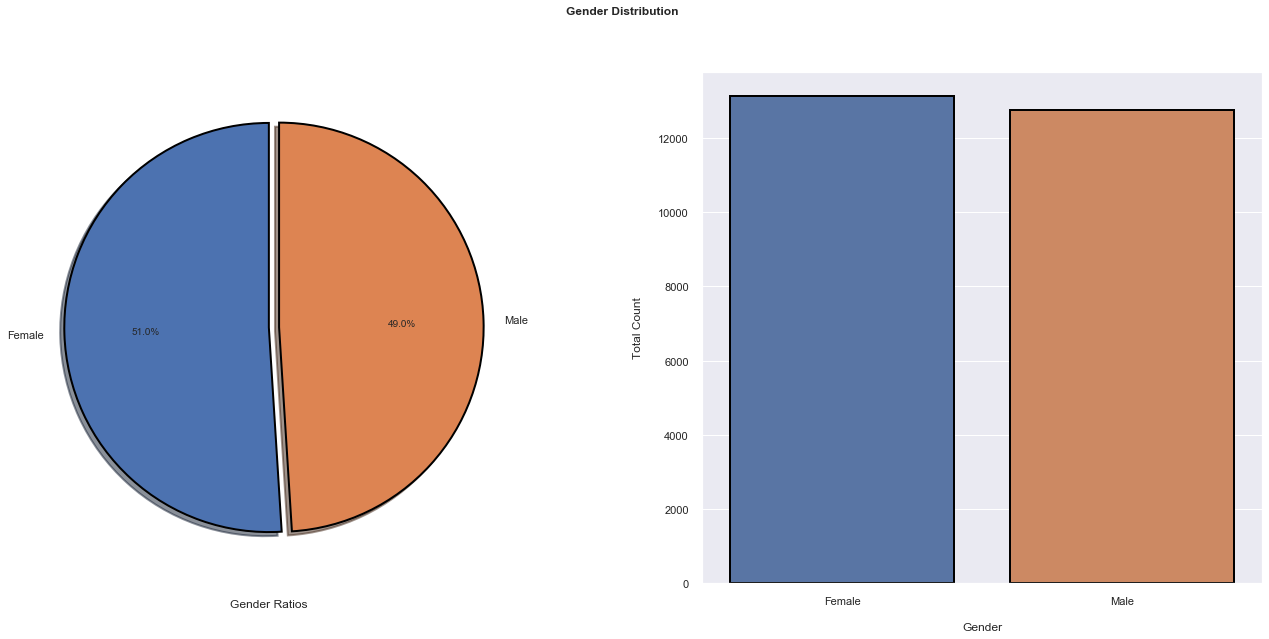

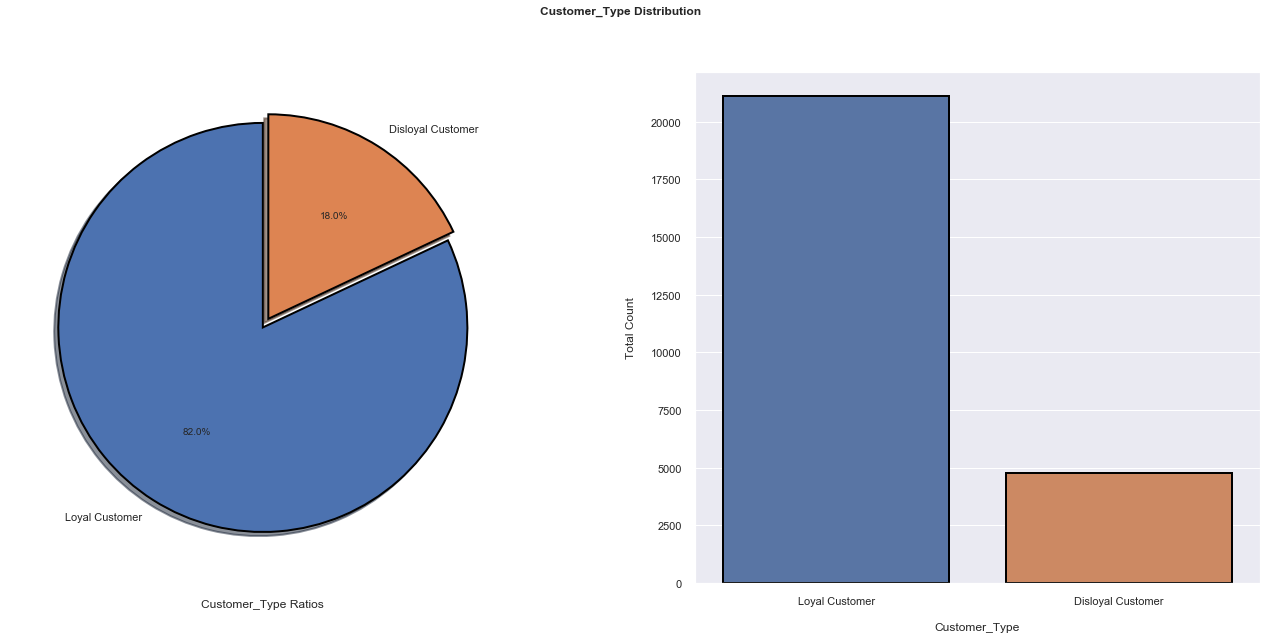

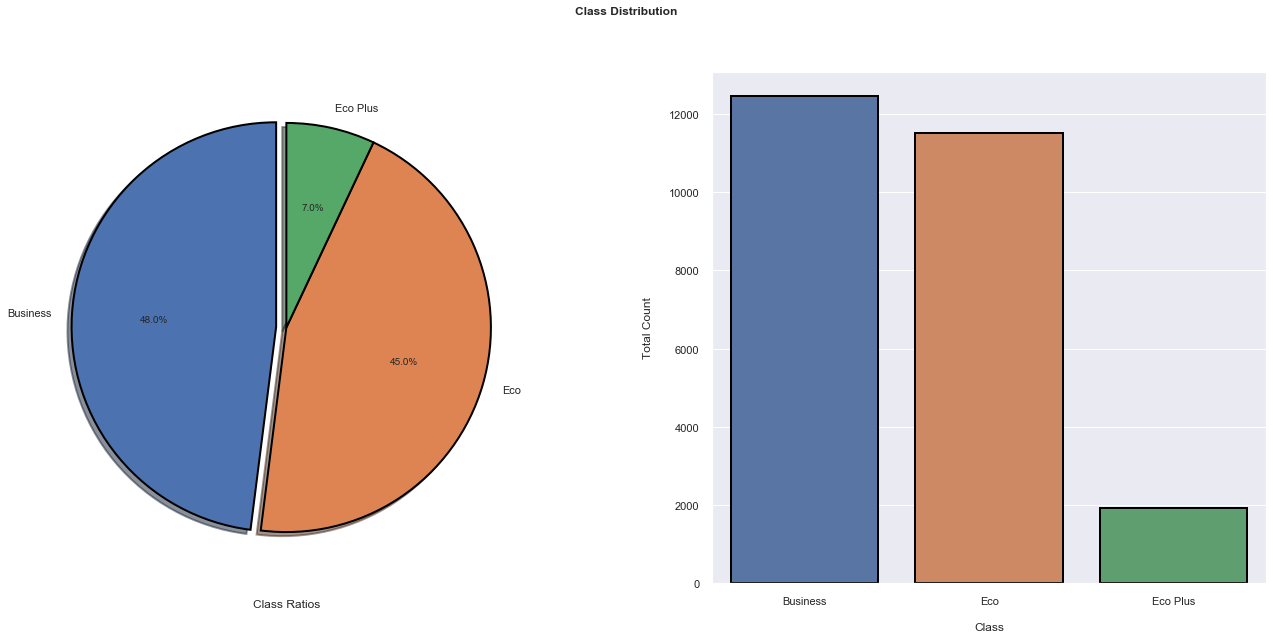

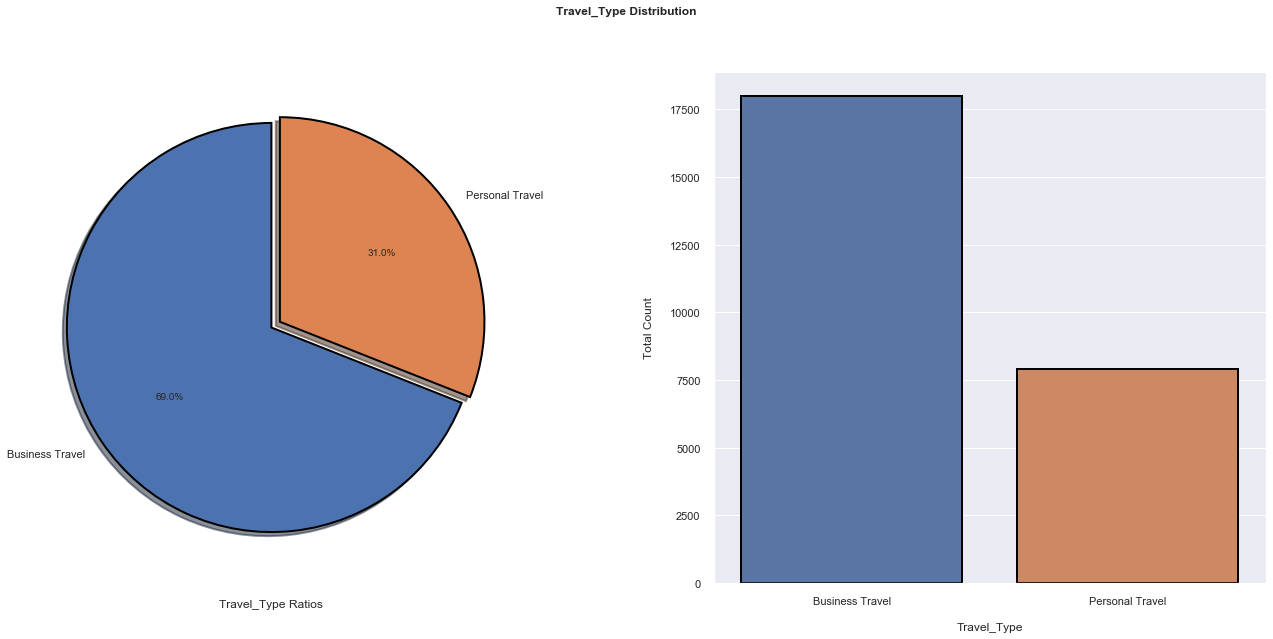

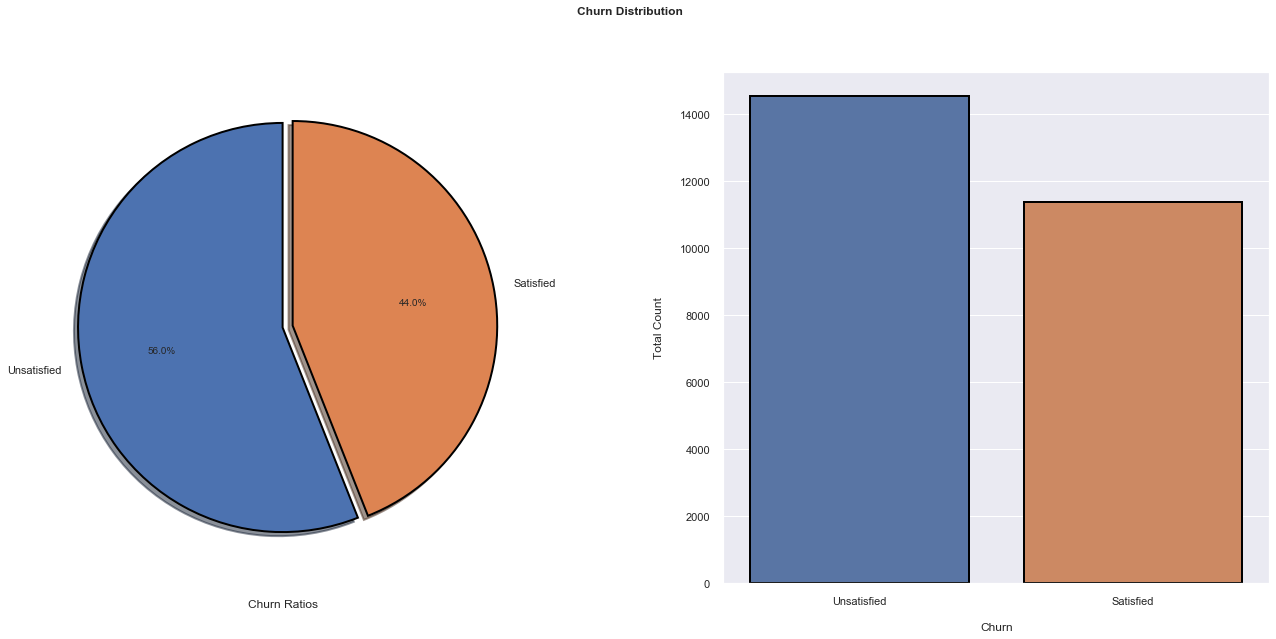

In [14]:
count=0
for i in ['Gender', 'Customer_Type', 'Class', 'Travel_Type', 'Churn']:
    _, axes=plt.subplots(1,2, figsize=(20,10))
    if len(set(aps[i]))==2:
        explode=(0,0.05)
    else:
        explode=(0.05,0,0)

    axes[0].pie(aps[i].value_counts(normalize=True).round(2), labels=aps[i].value_counts().to_dict(), 
                explode=explode, shadow=True, startangle=90, 
                wedgeprops = { 'linewidth' : 2, 'edgecolor' : "black" }, autopct='%1.1f%%')
    axes[0].set_xlabel(f'\n{i} Ratios')

    sns.countplot(aps[i], linewidth=2,order=aps[i].value_counts().index.to_list(), edgecolor='black', ax=axes[1])
    axes[1].set_ylabel('Total Count\n')
    axes[1].set_xlabel(f'\n{i}')

    _.suptitle(f'{i} Distribution',  fontweight='bold')
    _.tight_layout(pad=8)
    #plt.savefig(f'img{count}.png')
    #count+=1
    plt.show()

plt.rc('font', size=20)          
plt.rc('axes', titlesize=20)     
plt.rc('axes', labelsize=20)     
plt.rc('xtick', labelsize=20)    
plt.rc('ytick', labelsize=20)    
plt.rc('legend', fontsize=20)    
plt.rc('figure', titlesize=22)

In [15]:
dct={'Female':0, 'Male':1}
aps.Gender=aps.Gender.map(dct)

In [16]:
dct={'Disloyal Customer':0, 'Loyal Customer':1}
aps.Customer_Type=aps.Customer_Type.map(dct)

In [17]:
dct={'Business Travel':0, 'Personal Travel':1}
aps.Travel_Type=aps.Travel_Type.map(dct)

In [18]:
aps.Class=aps.Class.str.replace('Eco Plus','Eco_Plus')

In [19]:
dum_lst.append('Class')

In [20]:
dct={'Unsatisfied':0, 'Satisfied':1}
aps.Churn=aps.Churn.map(dct)

#### Incorrect Values

In [21]:
(aps._get_numeric_data()<0).sum()

Unnamed: 0                            0
id                                    0
Gender                                0
Customer_Type                         0
Age                                   0
Travel_Type                           0
Flight_Distance                       0
Inflight_Wifi                         0
Departure_Arrival_Time_Convenience    0
Ease_of_Online_Booking                0
Gate_Location                         0
Food_Drink                            0
Online_Boarding                       0
Seat_Comfort                          0
Inflight_Entertainment                0
On-board_Service                      0
Seat_Pitch                            0
Baggage_Handling                      0
Checkin_Service                       0
Inflight_Service                      0
Cleanliness                           0
Departure_Delay_min                   0
Arrival_Delay_min                     0
Churn                                 0
dtype: int64

#### Low Variance

In [22]:
low_variance = []
 
for col in aps._get_numeric_data():
    minimum = min(aps[col])
    ninety_perc = np.percentile(aps[col], 90)
    if ninety_perc == minimum:
        low_variance.append(col)

if not low_variance:
    print('No Low Variant Columns')
else:
    print(low_variance)

No Low Variant Columns


#### Data Type

In [23]:
aps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25893 entries, 0 to 25975
Data columns (total 25 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Unnamed: 0                          25893 non-null  int64  
 1   id                                  25893 non-null  int64  
 2   Gender                              25893 non-null  int64  
 3   Customer_Type                       25893 non-null  int64  
 4   Age                                 25893 non-null  int64  
 5   Travel_Type                         25893 non-null  int64  
 6   Class                               25893 non-null  object 
 7   Flight_Distance                     25893 non-null  int64  
 8   Inflight_Wifi                       25893 non-null  int64  
 9   Departure_Arrival_Time_Convenience  25893 non-null  int64  
 10  Ease_of_Online_Booking              25893 non-null  int64  
 11  Gate_Location                       25893

In [24]:
# Converting Arrival Delay to integer type
aps.Arrival_Delay_min=aps.Arrival_Delay_min.astype(int)

In [25]:
# Converting Churn to Categorical
aps.Churn=aps.Churn.astype(object)

#### Dropping Passenger ID and Unnamed column

In [26]:
aps.drop(['id','Unnamed: 0'], axis=1, inplace=True)

### Data Analysis

#### Descriptive Statistics

In [27]:
aps.describe().round(2)

,Gender,Customer_Type,Age,Travel_Type,Flight_Distance,Inflight_Wifi,Departure_Arrival_Time_Convenience,Ease_of_Online_Booking,Gate_Location,Food_Drink,Online_Boarding,Seat_Comfort,Inflight_Entertainment,On-board_Service,Seat_Pitch,Baggage_Handling,Checkin_Service,Inflight_Service,Cleanliness,Departure_Delay_min,Arrival_Delay_min
count,25893.00,25893.00,25893.00,25893.00,25893.00,25893.00,25893.00,25893.00,25893.00,25893.00,25893.00,25893.00,25893.00,25893.00,25893.00,25893.00,25893.00,25893.00,25893.00,25893.00,25893.00
mean,0.49,0.82,39.62,0.31,1193.75,2.72,3.05,2.76,2.98,3.21,3.26,3.45,3.36,3.39,3.35,3.63,3.31,3.65,3.29,14.23,14.74
std,0.50,0.39,15.13,0.46,998.63,1.33,1.53,1.41,1.28,1.33,1.36,1.32,1.34,1.28,1.32,1.18,1.27,1.18,1.32,37.19,37.52
min,0.00,0.00,7.00,0.00,31.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,27.00,0.00,414.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,3.00,3.00,3.00,2.00,0.00,0.00
50%,0.00,1.00,40.00,0.00,849.00,3.00,3.00,3.00,3.00,3.00,4.00,4.00,4.00,4.00,4.00,4.00,3.00,4.00,3.00,0.00,0.00
75%,1.00,1.00,51.00,1.00,1744.00,4.00,4.00,4.00,4.00,4.00,4.00,5.00,4.00,4.00,4.00,5.00,4.00,5.00,4.00,12.00,13.00
max,1.00,1.00,85.00,1.00,4983.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,1128.00,1115.00


In [28]:
x=aps.describe().iloc[1:3,6:19]
y=x.loc['mean',:].values
e=x.loc['std',:].values
x=x.columns

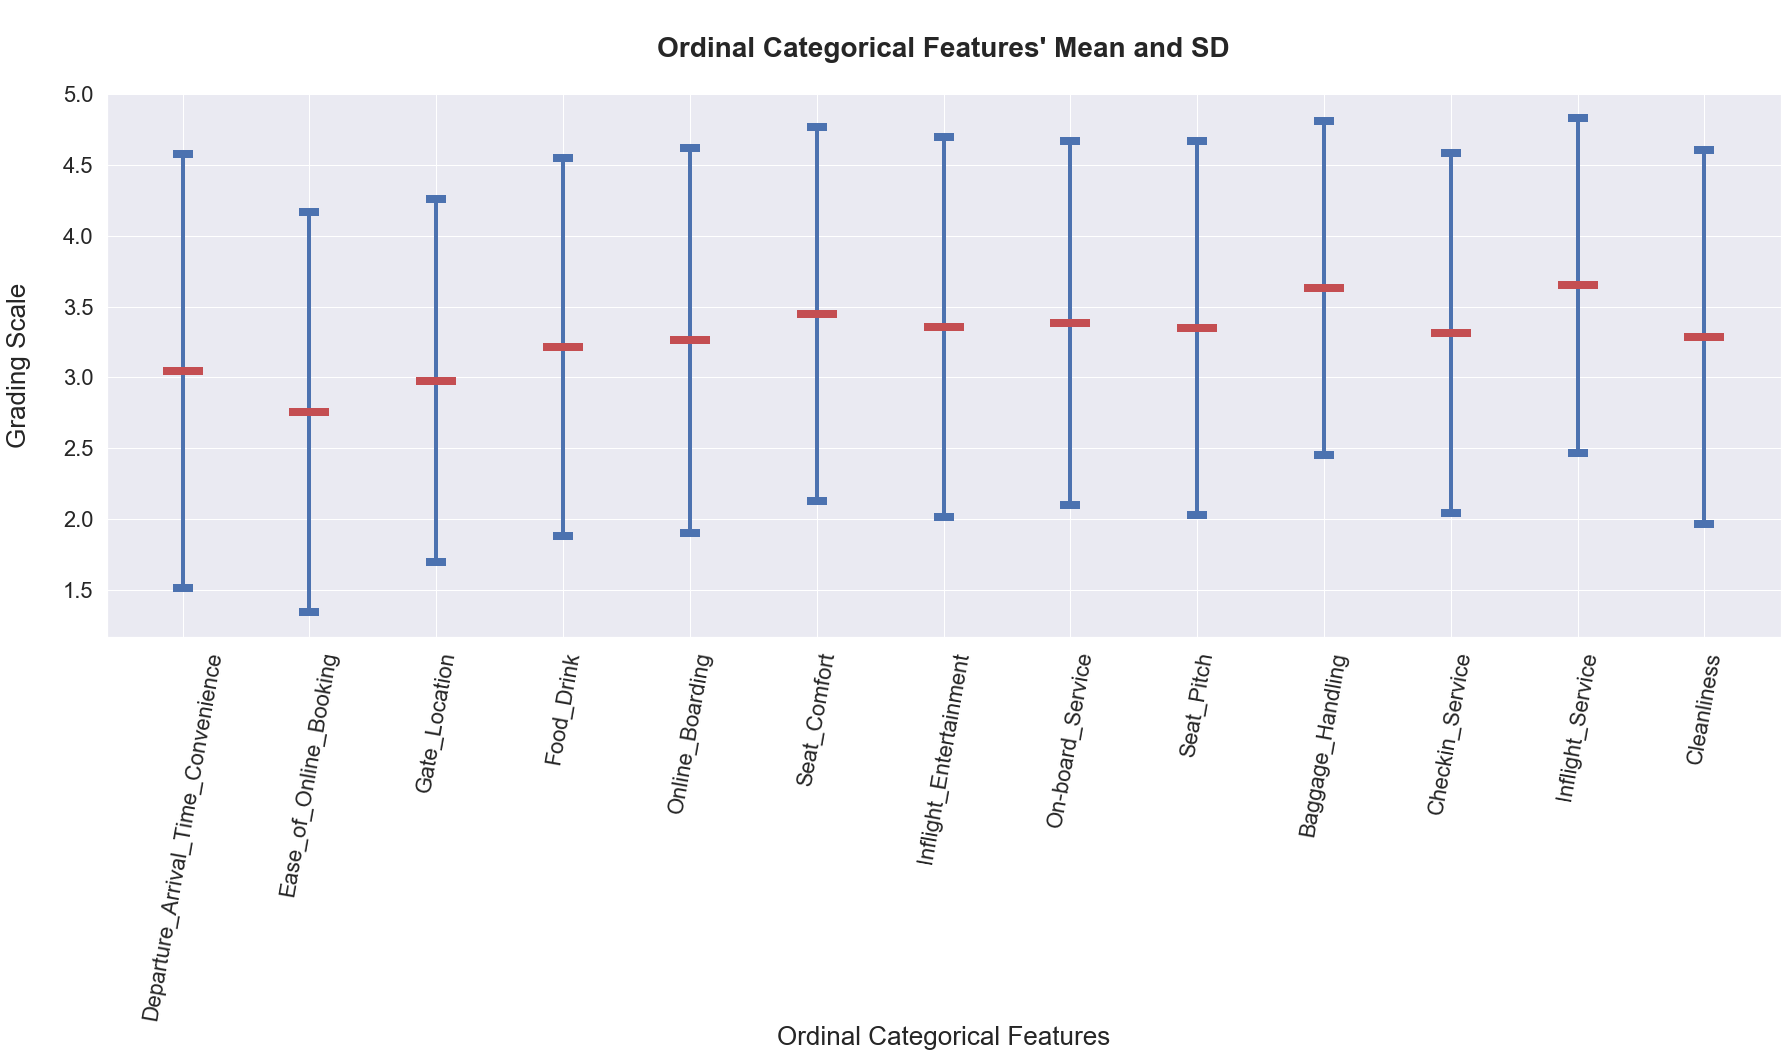

In [29]:
# Plotting of Ordinal Categorical Features (Means and StD) - Measure of Centrality and Variability
plt.figure(figsize=(30,10))
plt.errorbar(x, y, e,  linestyle='None', fmt='_', markersize=40, markerfacecolor='b', 
             elinewidth=4, capsize=10, capthick=6, mew=8, mec='r')

plt.xticks(fontsize= 22, rotation=80)
plt.yticks(fontsize= 22)
plt.title('\nOrdinal Categorical Features\' Mean and SD\n', fontweight='bold', fontsize= 28)
plt.xlabel(f'Ordinal Categorical Features', size=26)
plt.ylabel(f'Grading Scale\n', size=26);

#plt.savefig(f'img.png', bbox_inches='tight');

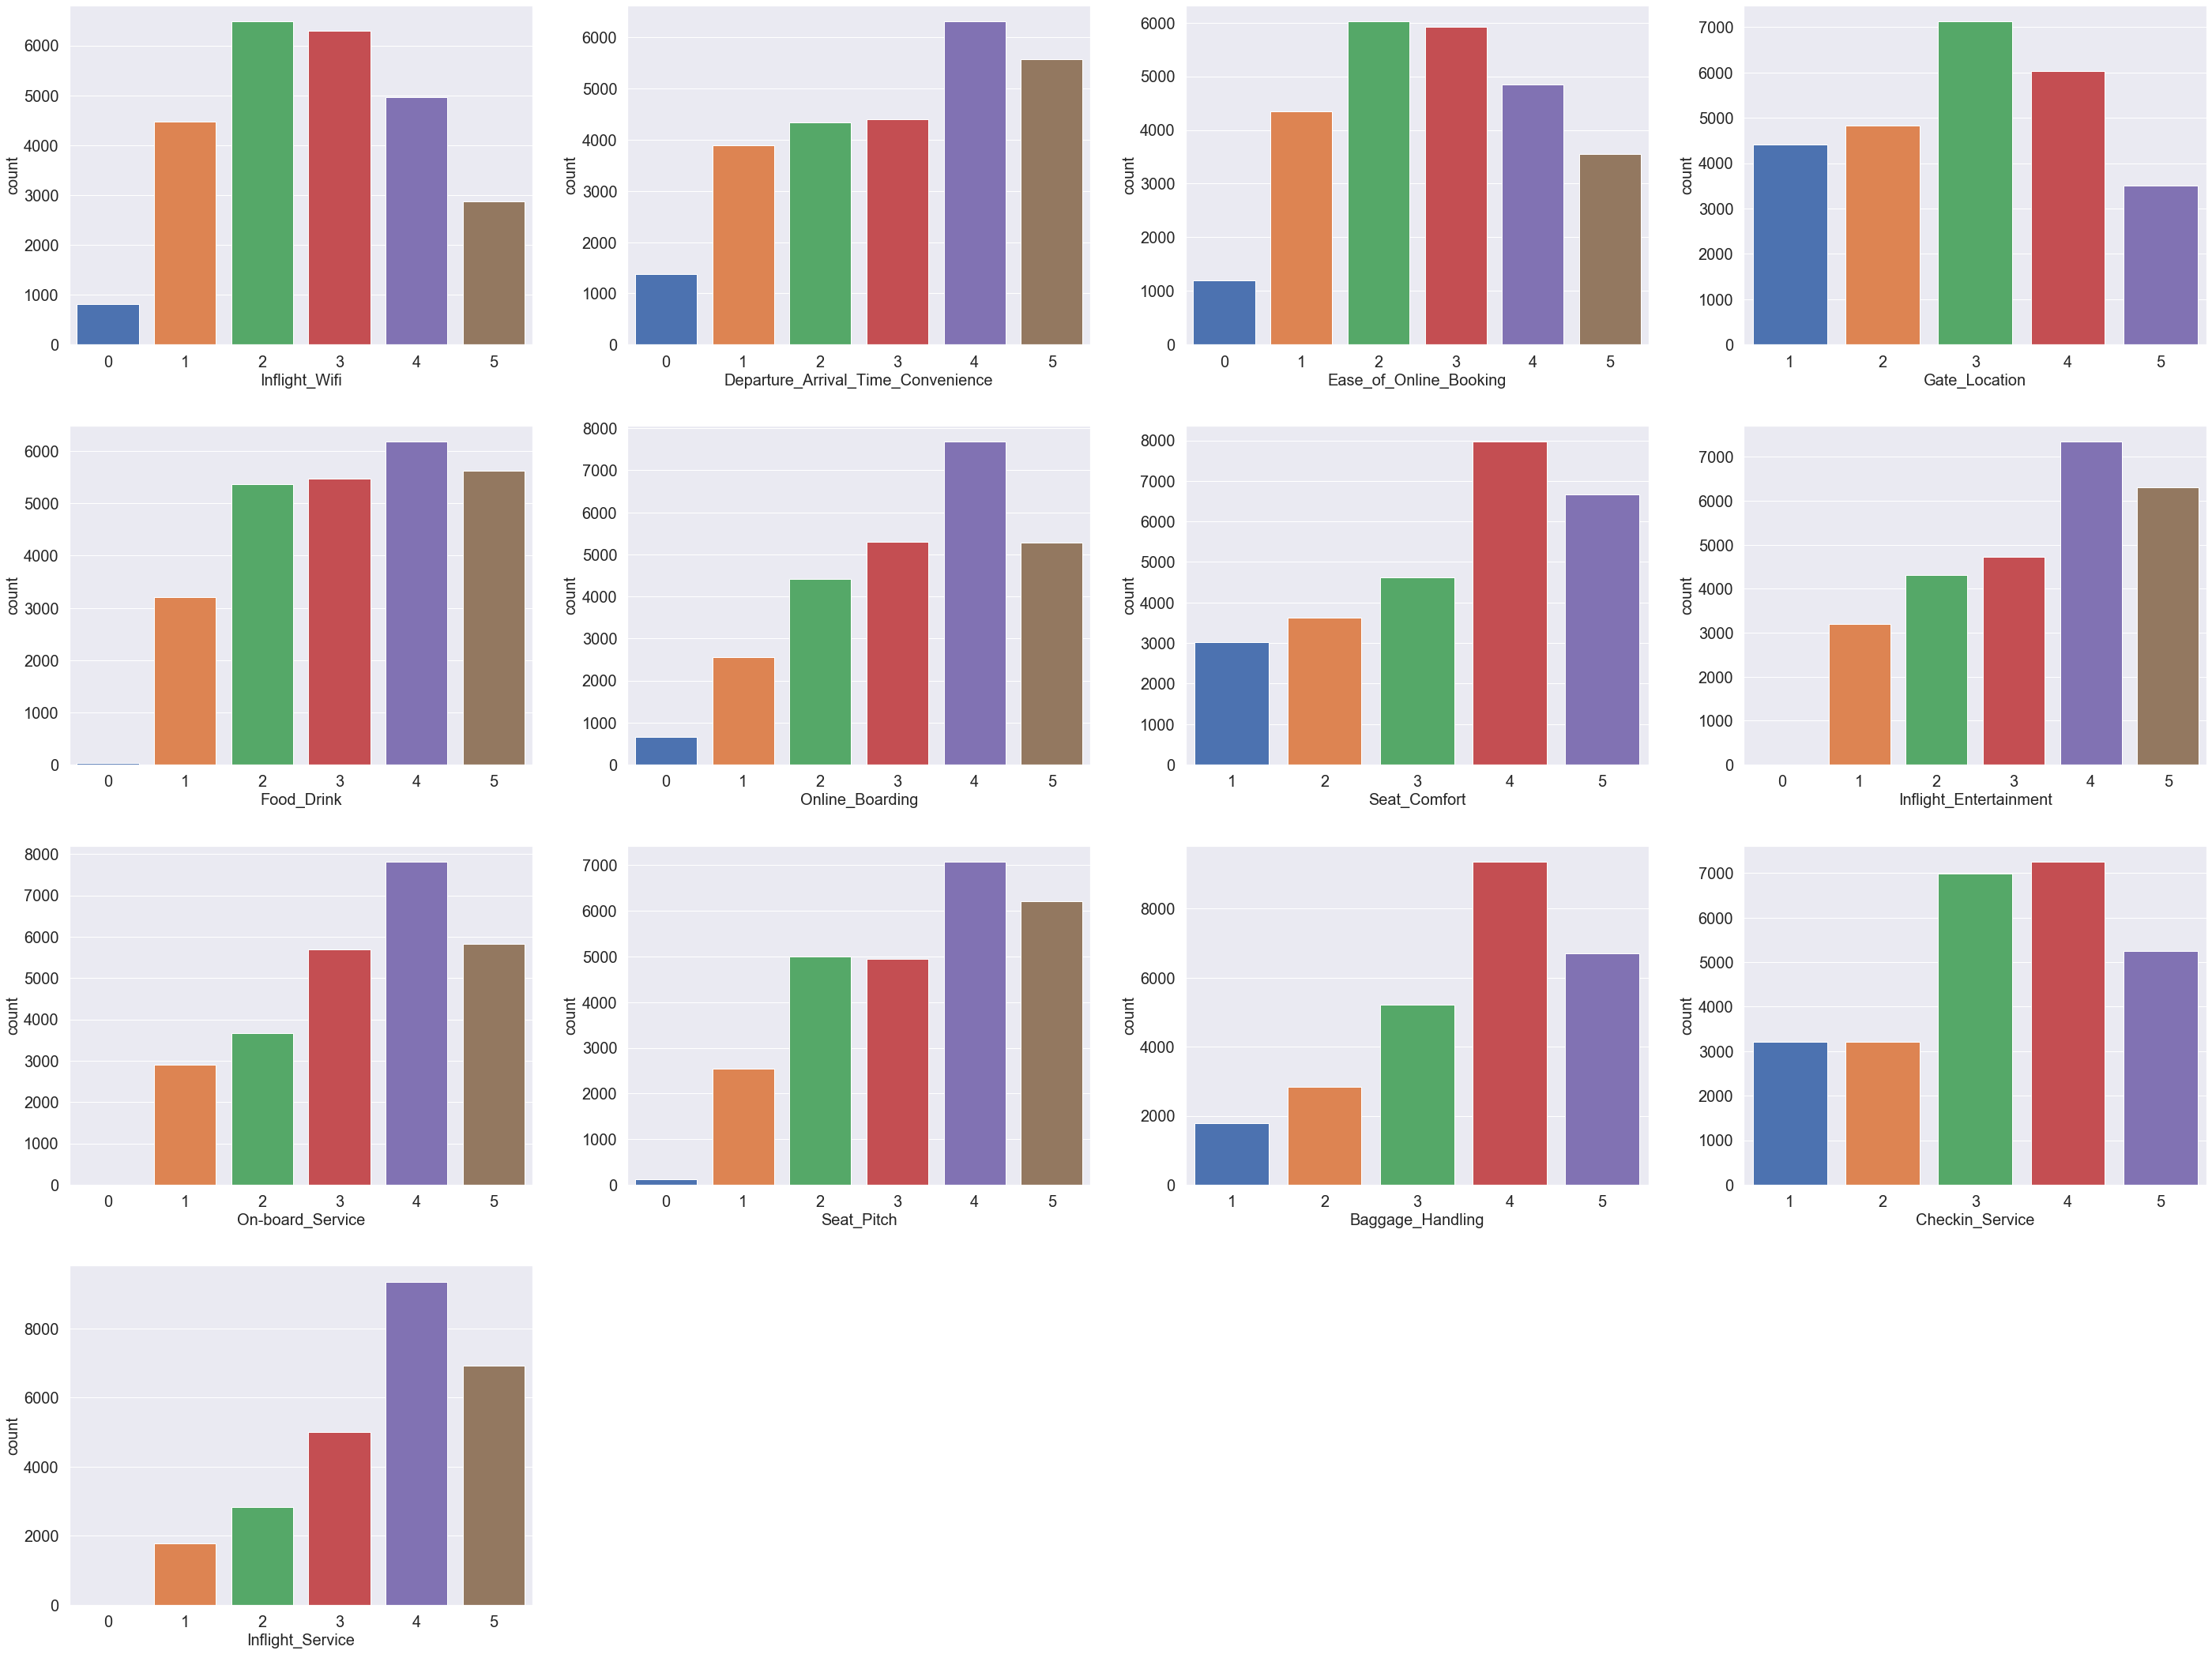

In [30]:
_, axes=plt.subplots(4,4, figsize=(40,30))
col=aps.iloc[:,6:19].columns

for idx, feature in enumerate (col):
    ax=axes[idx//4, idx%4]
    sns.countplot(aps[feature], ax=ax, saturation=1)

_.tight_layout(pad=2)
#_.suptitle('\nFrequency Distribution for our Ordinal Categorical Features\n')
#plt.rc('axes', labelsize=20)

_.delaxes(axes[3][1])
_.delaxes(axes[3][2])
_.delaxes(axes[3][3])

#plt.savefig(f'img.png', bbox_inches='tight');

#### Outliers  
Box-Plot

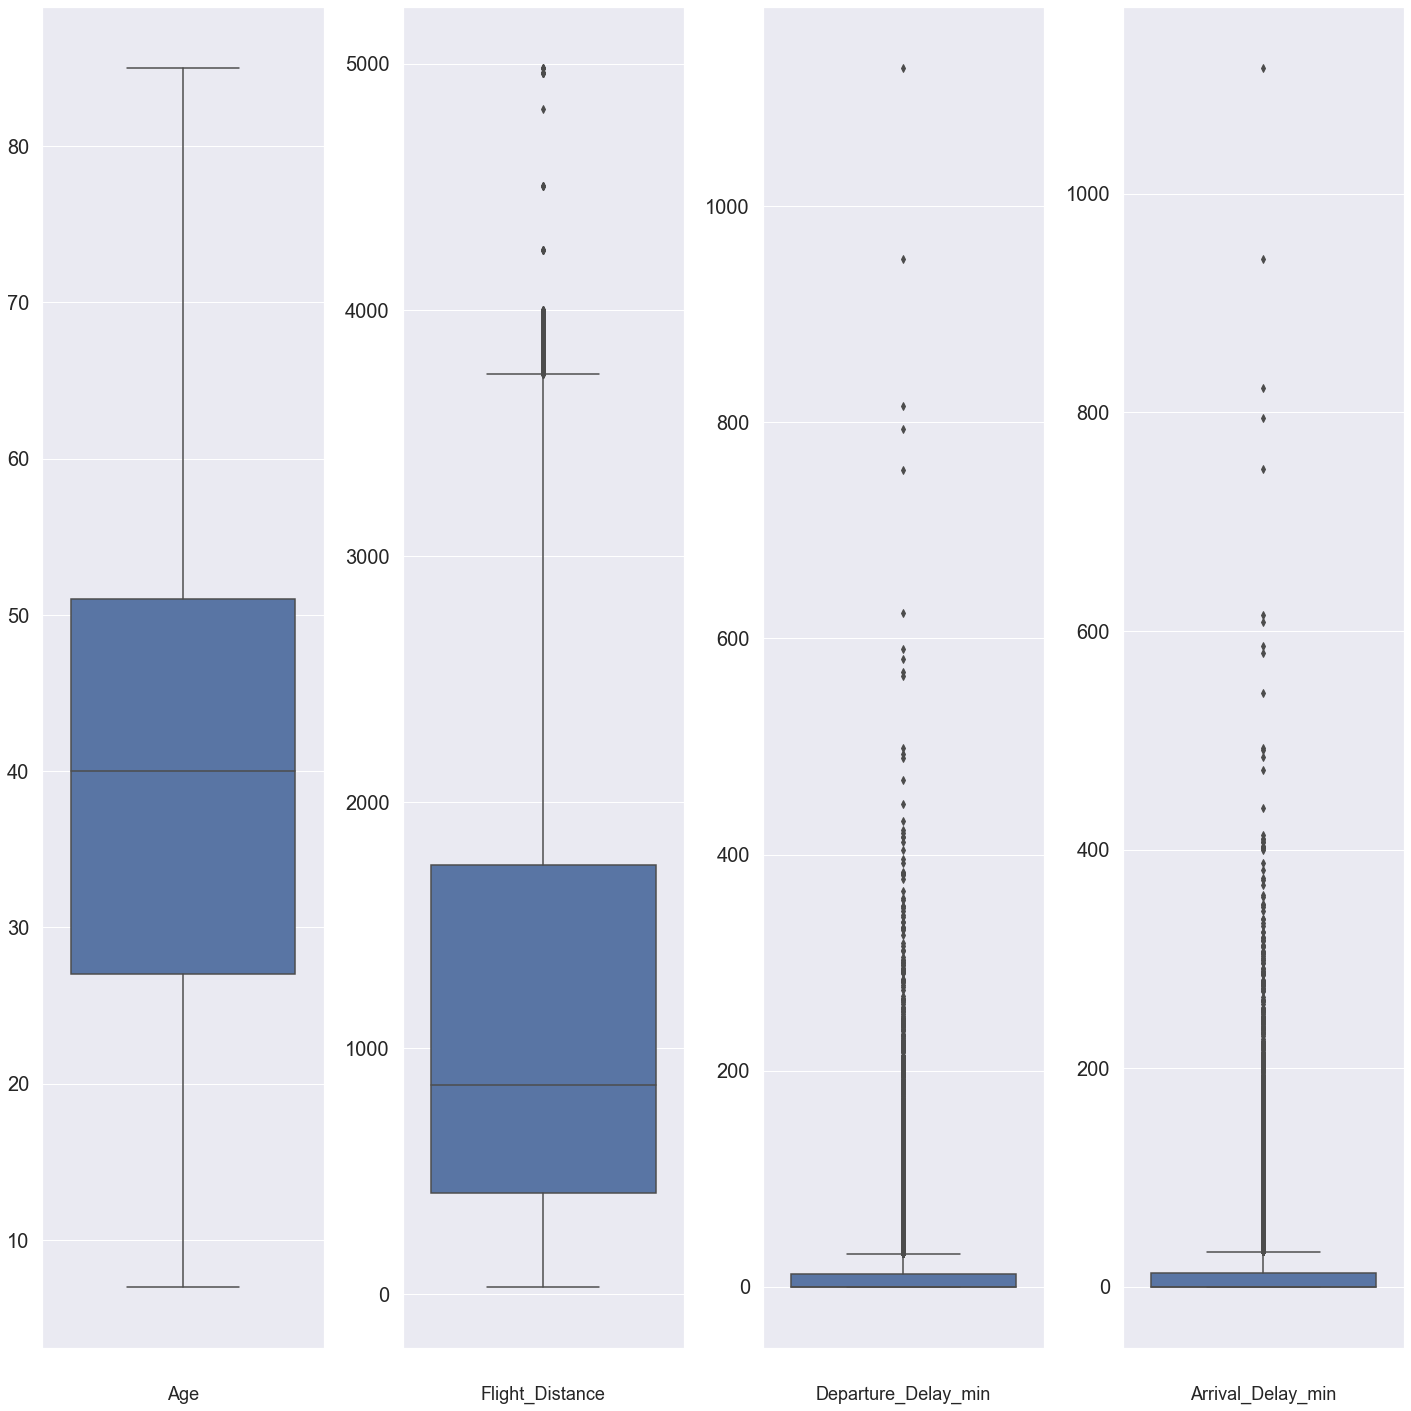

In [31]:
# Box-Plot to identify outliers in Features
num_features=['Age', 'Flight_Distance', 'Departure_Delay_min', 'Arrival_Delay_min']

fig, axes=plt.subplots(1,4,figsize=(20,20))
for idx,feature in enumerate(num_features):
    ax=axes[idx%4]
    sns.boxplot(y=aps[feature], ax=ax)
    ax.set_xlabel(f'\n{feature}', size=18)
    ax.set_ylabel(f'')
    
fig.tight_layout();

In [32]:
# IQR Method
stats=aps.describe()
stats=stats.T
stats['IQR']=stats['75%']-stats['25%']

outliers = pd.DataFrame(columns=aps.columns)

for col in stats.index:
    iqr=stats.IQR[col]
    cutoff=iqr*1.6
    lower=stats.at[col,'25%']-cutoff
    upper=stats.at[col,'75%']+cutoff
    results=aps[(aps[col]<lower)|(aps[col]>upper)].copy()
    results['Outlier']=col
    outliers=outliers.append(results)

In [33]:
# Almost 60% of Data are outliers in atleast on Feature -> Keep and remove only extreme ones based on Boxplot
outliers

,Gender,Customer_Type,Age,Travel_Type,Class,Flight_Distance,Inflight_Wifi,Departure_Arrival_Time_Convenience,Ease_of_Online_Booking,Gate_Location,Food_Drink,Online_Boarding,Seat_Comfort,Inflight_Entertainment,On-board_Service,Seat_Pitch,Baggage_Handling,Checkin_Service,Inflight_Service,Cleanliness,Departure_Delay_min,Arrival_Delay_min,Churn,Outlier
2,1,0,20,0,Eco,192,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0,0,0,Customer_Type
24,0,0,30,0,Eco,528,4,3,5,3,2,5,2,2,3,2,3,4,4,2,0,0,0,Customer_Type
32,1,0,41,0,Eco,624,2,3,2,4,5,2,5,5,4,3,3,1,4,5,0,0,0,Customer_Type
38,0,0,32,0,Business,802,4,4,4,2,2,4,4,2,4,2,4,3,5,2,0,10,0,Customer_Type
40,0,0,42,0,Business,373,3,3,3,5,4,3,4,4,3,2,5,5,5,4,0,0,0,Customer_Type
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25904,0,1,49,0,Business,3542,3,3,3,3,5,5,5,3,4,5,5,5,5,5,90,169,1,Arrival_Delay_min
25925,0,1,29,0,Business,689,2,2,2,2,3,3,3,3,4,2,5,5,5,3,48,46,1,Arrival_Delay_min
25934,0,1,41,0,Business,2748,1,2,2,2,1,4,4,1,1,1,1,3,1,3,83,79,0,Arrival_Delay_min
25935,0,1,39,0,Business,2291,2,2,1,1,5,2,2,2,2,2,2,1,2,1,70,64,0,Arrival_Delay_min


In [34]:
# Dropping Flight Distances > 4000
aps.drop(aps.loc[aps.Flight_Distance>4000].index, axis=0, inplace=True)

In [35]:
# Dropping Departure Delays > 600 min 
aps.drop(aps.loc[aps.Departure_Delay_min>450].index, axis=0, inplace=True)

In [36]:
# Dropping Arrival Delays > 500 min 
aps.drop(aps.loc[aps.Arrival_Delay_min>450].index, axis=0, inplace=True)

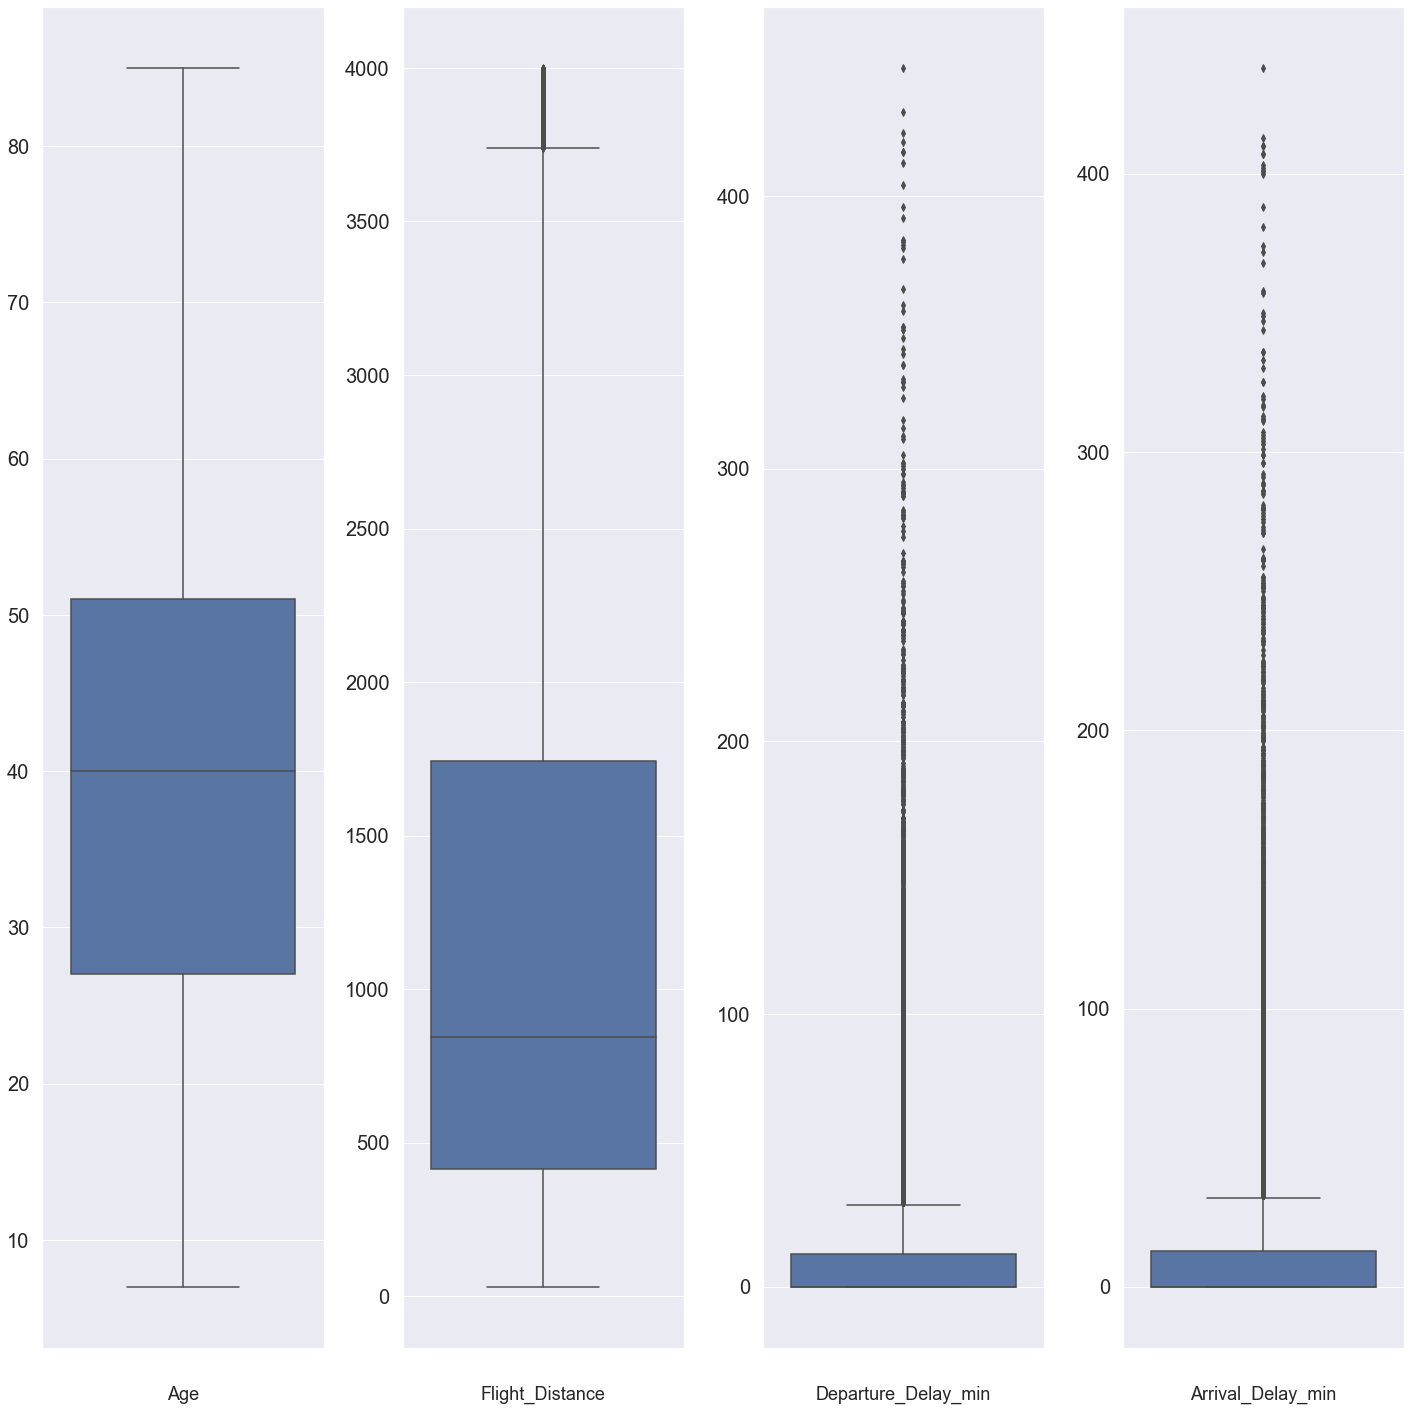

In [37]:
# Replotting to visualize distribution
fig, axes=plt.subplots(1,4,figsize=(20,20))
for idx,feature in enumerate(num_features):
    ax=axes[idx%4]
    sns.boxplot(y=aps[feature], ax=ax)
    ax.set_xlabel(f'\n{feature}', size=18)
    ax.set_ylabel(f'')

fig.tight_layout();

#### Correlations
Heatmap

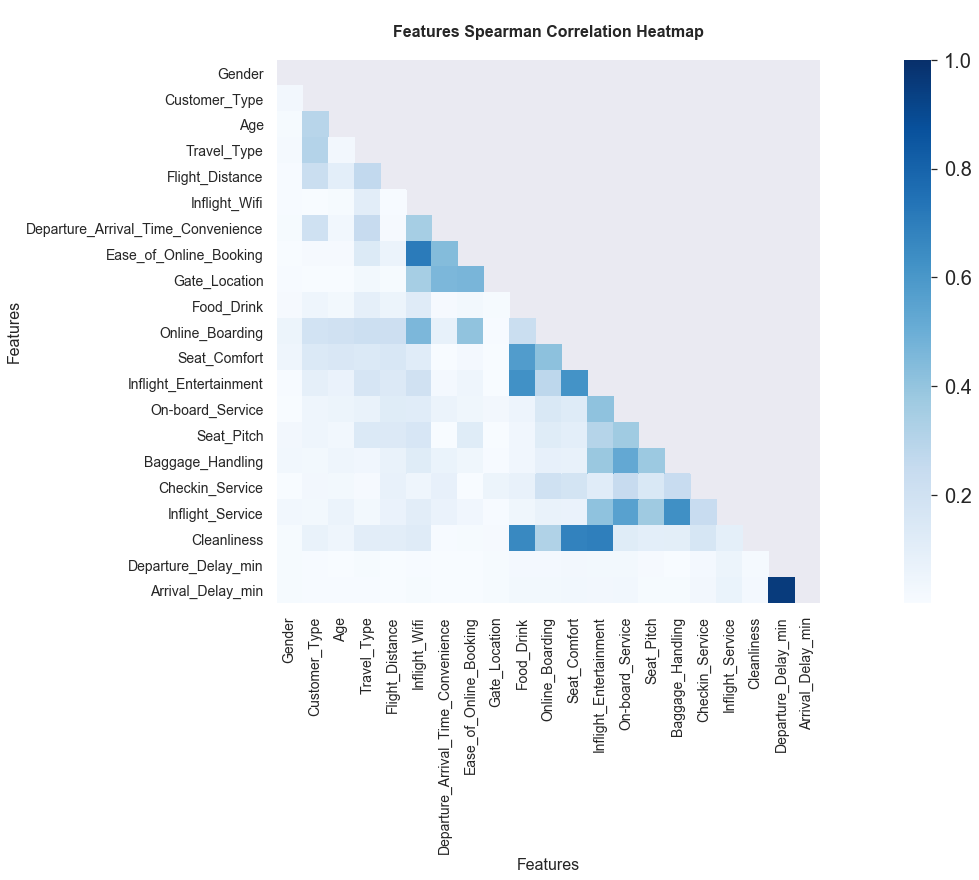

In [38]:
# Correlation Heatmap -> Spearman since the majority of my features are ordinal
plt.figure(figsize=(30,10))

mask = np.zeros_like(abs(aps.drop('Churn',axis=1).corr(method='spearman')))
mask[np.triu_indices_from(mask)] = True
sns.heatmap(abs(aps.drop('Churn',axis=1).corr()), mask=mask, cmap="Blues", square=True)

plt.title('\nFeatures Spearman Correlation Heatmap\n', fontweight='bold', fontsize=16)
plt.xlabel(f'Features', size=16)
plt.ylabel(f'Features', size=16)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14);

#plt.savefig(f'img.png', bbox_inches='tight');

#### Inferential Statistics

Analyze Population's Characteristic based on our Data Sampling

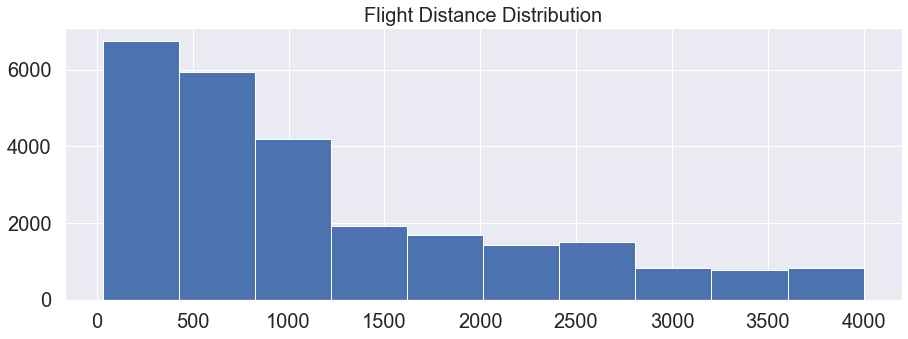

In [39]:
plt.figure(figsize=(15,5))
aps.Flight_Distance.hist()
plt.title('Flight Distance Distribution');

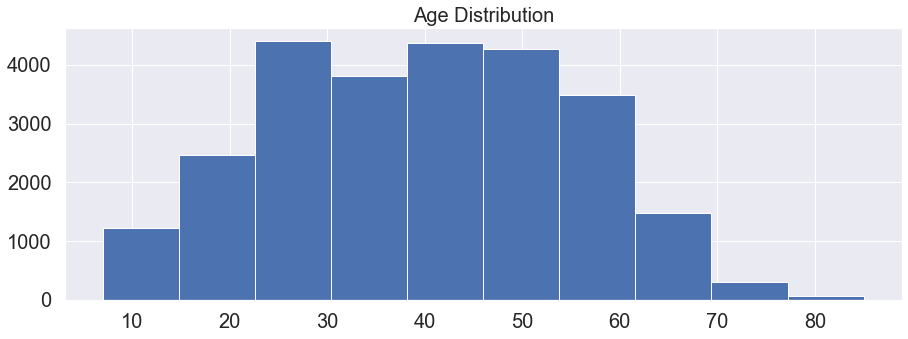

In [40]:
# Age
plt.figure(figsize=(15,5))
aps.Age.hist()
plt.title('Age Distribution');

In [41]:
# 95% Confidence Interval of Age 
print(f"Population Mean Age w/ 95% Confidence: {st.t.interval(0.95, df=(aps.Age.shape[0]-1), loc=aps.Age.mean(),scale=aps.Age.std()/(aps.Age.shape[0]**0.5))}")

Population Mean Age w/ 95% Confidence: (39.43687444203527, 39.805865029715385)


In [42]:
# Gender - (Male or Female)
dct={'Customer_Type': 'Loyal Members', 'Gender':'Male', 'Travel_Type':'Personal Travel'}
for i,j in dct.items() :
    p=(aps[i]==1).sum()/aps[i].shape[0]
    se=(p*(1-p)/aps[i].shape[0])**0.5
    ci=st.t.interval(0.95, df=(aps[i].shape[0]-1), loc=p, scale=se)
    print(f"Proportion of {j} w/ 95% Confidence: [{round(ci[0],4)} , {round(ci[1],4)}]\n")

Proportion of Loyal Members w/ 95% Confidence: [0.8105 , 0.82]

Proportion of Male w/ 95% Confidence: [0.487 , 0.4992]

Proportion of Personal Travel w/ 95% Confidence: [0.3001 , 0.3114]



In [43]:
aps

,Gender,Customer_Type,Age,Travel_Type,Class,Flight_Distance,Inflight_Wifi,Departure_Arrival_Time_Convenience,Ease_of_Online_Booking,Gate_Location,Food_Drink,Online_Boarding,Seat_Comfort,Inflight_Entertainment,On-board_Service,Seat_Pitch,Baggage_Handling,Checkin_Service,Inflight_Service,Cleanliness,Departure_Delay_min,Arrival_Delay_min,Churn
0,0,1,52,0,Eco,160,5,4,3,4,3,4,3,5,5,5,5,2,5,5,50,44,1
1,0,1,36,0,Business,2863,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0,0,1
2,1,0,20,0,Eco,192,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0,0,0
3,1,1,44,0,Business,3377,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0,6,1
4,0,1,49,0,Eco,1182,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0,20,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25971,1,0,34,0,Business,526,3,3,3,1,4,3,4,4,3,2,4,4,5,4,0,0,0
25972,1,1,23,0,Business,646,4,4,4,4,4,4,4,4,4,5,5,5,5,4,0,0,1
25973,0,1,17,1,Eco,828,2,5,1,5,2,1,2,2,4,3,4,5,4,2,0,0,0
25974,1,1,14,0,Business,1127,3,3,3,3,4,4,4,4,3,2,5,4,5,4,0,0,1


#### Hypothesis Testing
I want to test whether the average Arrival and Departure Delay are of same distribution, to check whether the cause of delay is solely from the departure.

More specifically, I want to determine whether it is equally likely that any randomly selected observation from one sample will be greater or less than a sample in the other distribution.

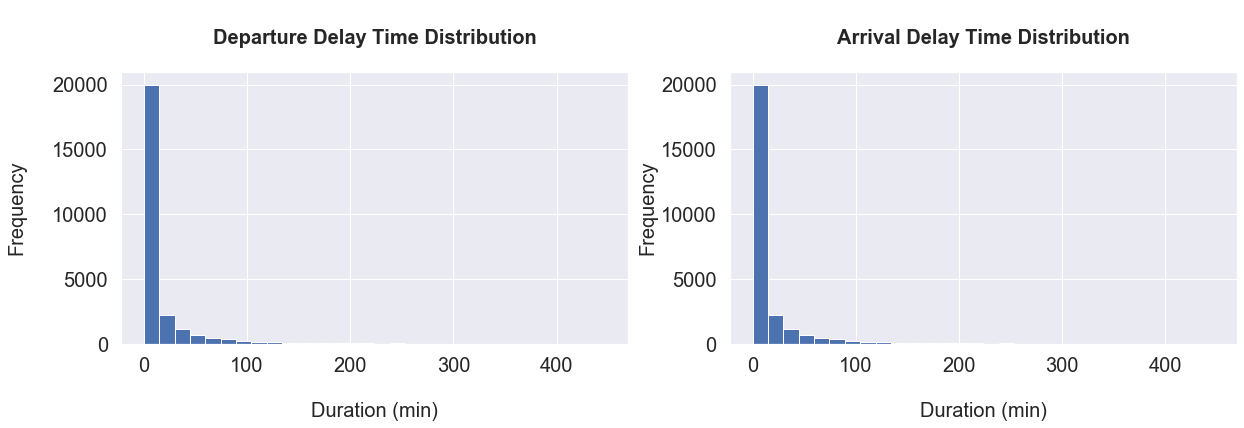

In [44]:
# Plotting Frequency Distribution for Delay Time and Arrival Time
plt.figure(figsize=(20,5))

plt.subplot(121)
aps.Departure_Delay_min.plot(kind='hist', bins=30)
plt.title(f'\nDeparture Delay Time Distribution\n', fontweight='bold')
plt.xlabel(f'\nDuration (min)')
plt.ylabel(f'Frequency\n')

plt.subplot(122)
aps.Departure_Delay_min.plot(kind='hist', bins=30)
plt.title(f'\nArrival Delay Time Distribution\n', fontweight='bold')
plt.xlabel(f'\nDuration (min)')
plt.ylabel(f'Frequency');

#plt.savefig(f'img.png', bbox_inches='tight');

Wilcoxon Signed-Rank Test

In [45]:
stat, p = wilcoxon(aps.Departure_Delay_min , aps.Arrival_Delay_min)
print(f'Test Statistic: {stat} , P-Value: {p}')

Test Statistic: 45078775.5 , P-Value: 0.0008712122209636873


Mann-Whitney U Test

In [46]:
stat, p = mannwhitneyu(aps.Departure_Delay_min, aps.Arrival_Delay_min)
print(f'Test Statistic: {stat} , P-Value: {p}')

Test Statistic: 331600553.5 , P-Value: 0.03711117346255604


In [47]:
aps

,Gender,Customer_Type,Age,Travel_Type,Class,Flight_Distance,Inflight_Wifi,Departure_Arrival_Time_Convenience,Ease_of_Online_Booking,Gate_Location,Food_Drink,Online_Boarding,Seat_Comfort,Inflight_Entertainment,On-board_Service,Seat_Pitch,Baggage_Handling,Checkin_Service,Inflight_Service,Cleanliness,Departure_Delay_min,Arrival_Delay_min,Churn
0,0,1,52,0,Eco,160,5,4,3,4,3,4,3,5,5,5,5,2,5,5,50,44,1
1,0,1,36,0,Business,2863,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0,0,1
2,1,0,20,0,Eco,192,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0,0,0
3,1,1,44,0,Business,3377,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0,6,1
4,0,1,49,0,Eco,1182,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0,20,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25971,1,0,34,0,Business,526,3,3,3,1,4,3,4,4,3,2,4,4,5,4,0,0,0
25972,1,1,23,0,Business,646,4,4,4,4,4,4,4,4,4,5,5,5,5,4,0,0,1
25973,0,1,17,1,Eco,828,2,5,1,5,2,1,2,2,4,3,4,5,4,2,0,0,0
25974,1,1,14,0,Business,1127,3,3,3,3,4,4,4,4,3,2,5,4,5,4,0,0,1


### Feature Engineering

#### General Scaling

In [48]:
# Flight Distance - Divided it by 100
aps.Flight_Distance=aps.Flight_Distance/100

# Age - Divided it by 10
aps.Age=aps.Age/10

# Departure_Delay_min - Divided it by 10 
aps.Departure_Delay_min=aps.Departure_Delay_min/10

# Arrival_Delay_min - Divided it by 10 
aps.Arrival_Delay_min=aps.Arrival_Delay_min/10


#### catcla & numcla Models

In [49]:
catcla=aps.copy()
numcla=aps.copy()

In [50]:
catcla.drop('Churn', axis=1, inplace=True)
numcla.drop('Churn', axis=1, inplace=True)

In [51]:
catcla=catcla.reset_index(drop=True)
numcla=numcla.reset_index(drop=True)

#### numcla

Dummies

In [52]:
numcla=pd.get_dummies(data=numcla, columns=dum_lst)

#### Assumptions

Multi-Collinearity

In [53]:
# Check for multi-collinearity for Logistic Regression Model
vifs=pd.Series([VIF(numcla.values,i) for i in range(numcla.shape[1])],
               index=numcla.columns)
vifs[vifs>10]

Departure_Delay_min    11.882884
Arrival_Delay_min      11.900342
Class_Business         26.118630
Class_Eco              19.000621
dtype: float64

In [54]:
drop_col=[]
def func(column, X):
    if column:
        X=X.drop(column, axis=1)
    vifs=pd.Series([VIF(X.values,i) for i in range(X.shape[1])],
                   index=X.columns)
    display(vifs[vifs>10])
    drop_col.append(column)
    return X

In [63]:
numcla=func('Online_Boarding', numcla)

Series([], dtype: float64)

In [64]:
drop_col

['Class_Business',
 'Inflight_Entertainment',
 'Inflight_Service',
 'Seat_Comfort',
 'Baggage_Handling',
 'Arrival_Delay_min',
 'Cleanliness',
 'Ease_of_Online_Booking',
 'Online_Boarding']

#### catcla 

Nominal Categorical X-formation

In [65]:
dct={'Business':2, 'Eco':0, 'Eco_Plus':1}
catcla.Class=catcla.Class.map(dct)

In [66]:
catcla

,Gender,Customer_Type,Age,Travel_Type,Class,Flight_Distance,Inflight_Wifi,Departure_Arrival_Time_Convenience,Ease_of_Online_Booking,Gate_Location,Food_Drink,Online_Boarding,Seat_Comfort,Inflight_Entertainment,On-board_Service,Seat_Pitch,Baggage_Handling,Checkin_Service,Inflight_Service,Cleanliness,Departure_Delay_min,Arrival_Delay_min
0,0,1,5.2,0,0,1.60,5,4,3,4,3,4,3,5,5,5,5,2,5,5,5.0,4.4
1,0,1,3.6,0,2,28.63,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0.0,0.0
2,1,0,2.0,0,0,1.92,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0.0,0.0
3,1,1,4.4,0,2,33.77,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0.0,0.6
4,0,1,4.9,0,0,11.82,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25854,1,0,3.4,0,2,5.26,3,3,3,1,4,3,4,4,3,2,4,4,5,4,0.0,0.0
25855,1,1,2.3,0,2,6.46,4,4,4,4,4,4,4,4,4,5,5,5,5,4,0.0,0.0
25856,0,1,1.7,1,0,8.28,2,5,1,5,2,1,2,2,4,3,4,5,4,2,0.0,0.0
25857,1,1,1.4,0,2,11.27,3,3,3,3,4,4,4,4,3,2,5,4,5,4,0.0,0.0


#### Feature Selection

In [67]:
# Feature Selection - Choosing the features that makes best sense together
def featselec(filt, j, df):
    selection=SelectKBest(filt, k=j)
    fit=selection.fit(df ,aps['Churn'].astype(int))
    return fit

In [68]:
def featselecDF(fit, df):
    cols = fit.get_support(indices=True)
    return df.iloc[:,cols]

In [69]:
def featscore(fit, df):
    dfscores=pd.DataFrame(fit.scores_)
    dfcolumns=pd.DataFrame(df.columns)
    FeatSelecScores = pd.concat([dfcolumns,dfscores],axis=1)
    FeatSelecScores.columns = ['Specs','Score'] 
    return FeatSelecScores.nlargest(10,'Score')

In [70]:
def featscoreplot(fit, filt, df):
    feat=featscore(fit, df)
    bars=feat.Specs.to_list()
    ax=feat.plot(kind='barh', figsize=(20,10))
    ax.set_yticklabels(bars, size=14)
    ax.tick_params(axis="x", labelsize=14)
    plt.title(f'\nFeatures {filt} Score\n', fontweight='bold', size=20)
    plt.xlabel(f'\nScore', size=18)
    plt.ylabel(f'Features\n', size=18);

Filter Method - F-Classification

In [71]:
fit1=featselec(f_classif, 7, numcla)

In [72]:
featselecDF(fit1, numcla)

,Travel_Type,Flight_Distance,Inflight_Wifi,On-board_Service,Seat_Pitch,Checkin_Service,Class_Eco
0,0,1.60,5,5,5,2,1
1,0,28.63,1,4,4,3,0
2,0,1.92,2,4,1,2,1
3,0,33.77,0,1,1,3,0
4,0,11.82,2,2,2,4,1
...,...,...,...,...,...,...,...
25854,0,5.26,3,3,2,4,0
25855,0,6.46,4,4,5,5,0
25856,1,8.28,2,4,3,5,1
25857,0,11.27,3,3,2,4,0


In [73]:
featscore(fit1, numcla)

,Specs,Score
3,Travel_Type,6675.128284
13,Class_Eco,6305.254698
9,On-board_Service,2993.786862
10,Seat_Pitch,2750.551620
4,Flight_Distance,2485.665144
5,Inflight_Wifi,2196.418329
11,Checkin_Service,1601.728371
8,Food_Drink,1268.565078
1,Customer_Type,859.170709
2,Age,387.383793


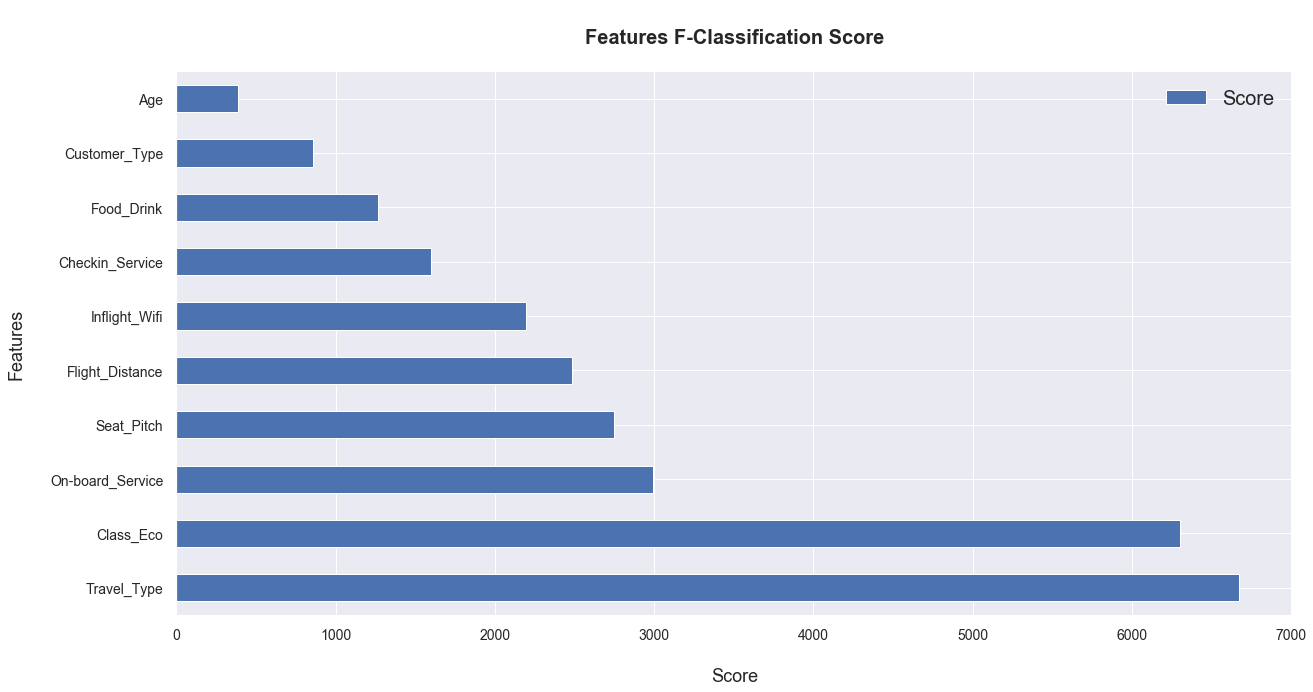

In [74]:
featscoreplot(fit1, 'F-Classification', numcla)

Chi-2

Method 1 - Transforming Flight Distance and Departure Delay into Ordinal Categorical Variable due their large scale

In [75]:
xxx=numcla.copy()

In [76]:
xxx.Flight_Distance=xxx.Flight_Distance.apply(lambda x: 0 if (0<=x<10) else 1 if (10<=x<20) 
                                              else 2 if (20<=x<30) else 3)

In [77]:
xxx.Departure_Delay_min=xxx.Departure_Delay_min.apply(lambda x: 0 if (x==0) else 1)

In [78]:
fit2=featselec(chi2, 7, xxx)
featselecDF(fit2, xxx)
featscore(fit2, xxx)

,Specs,Score
3,Travel_Type,3683.699297
4,Flight_Distance,2961.145851
13,Class_Eco,2812.660058
5,Inflight_Wifi,1324.026380
9,On-board_Service,1302.628016
10,Seat_Pitch,1292.013344
11,Checkin_Service,733.054431
8,Food_Drink,666.955076
14,Class_Eco_Plus,283.265611
2,Age,220.706937


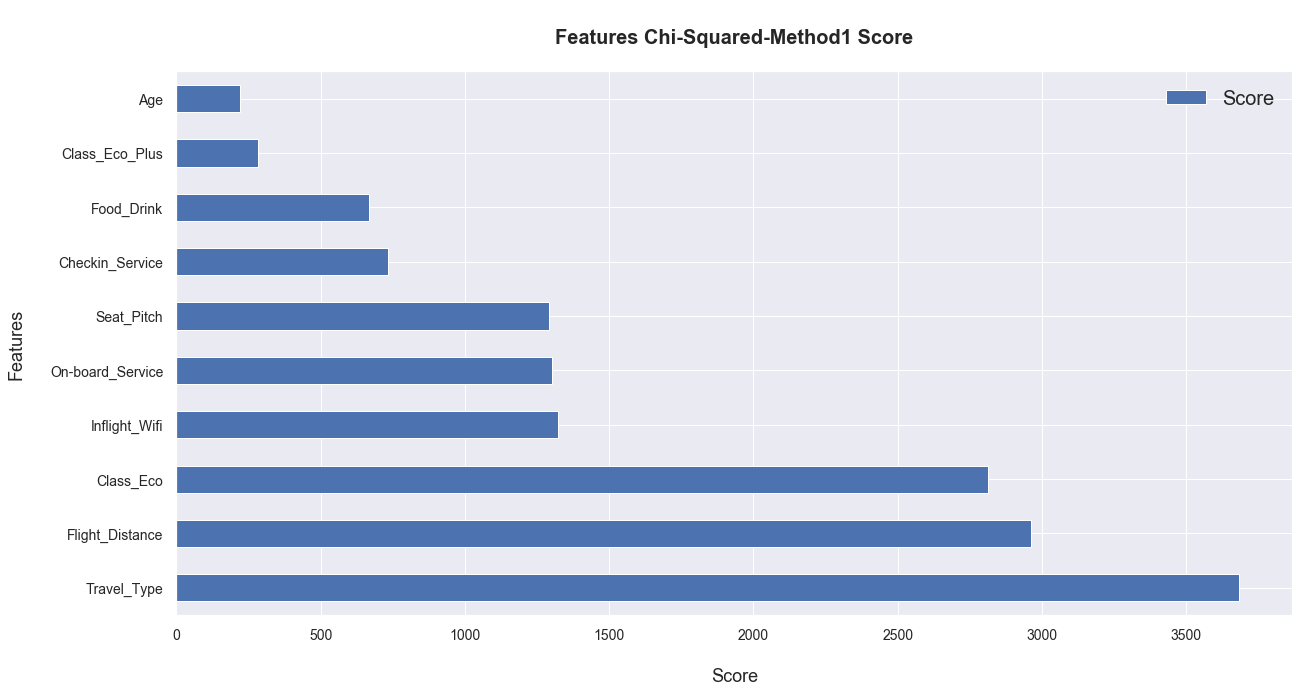

In [79]:
featscoreplot(fit2, 'Chi-Squared-Method1', xxx);

Method 2 - Keep the Dataset as is with the numerical values

In [80]:
# Works best for categorical data (If u had numerical values -> Bin them)
fit3=featselec(chi2, 7, numcla)

In [81]:
featselecDF(fit3, numcla)

,Travel_Type,Flight_Distance,Inflight_Wifi,On-board_Service,Seat_Pitch,Checkin_Service,Class_Eco
0,0,1.60,5,5,5,2,1
1,0,28.63,1,4,4,3,0
2,0,1.92,2,4,1,2,1
3,0,33.77,0,1,1,3,0
4,0,11.82,2,2,2,4,1
...,...,...,...,...,...,...,...
25854,0,5.26,3,3,2,4,0
25855,0,6.46,4,4,5,5,0
25856,1,8.28,2,4,3,5,1
25857,0,11.27,3,3,2,4,0


In [82]:
featscore(fit3, numcla)

,Specs,Score
4,Flight_Distance,18822.105368
3,Travel_Type,3683.699297
13,Class_Eco,2812.660058
5,Inflight_Wifi,1324.026380
9,On-board_Service,1302.628016
10,Seat_Pitch,1292.013344
11,Checkin_Service,733.054431
8,Food_Drink,666.955076
12,Departure_Delay_min,621.386373
14,Class_Eco_Plus,283.265611


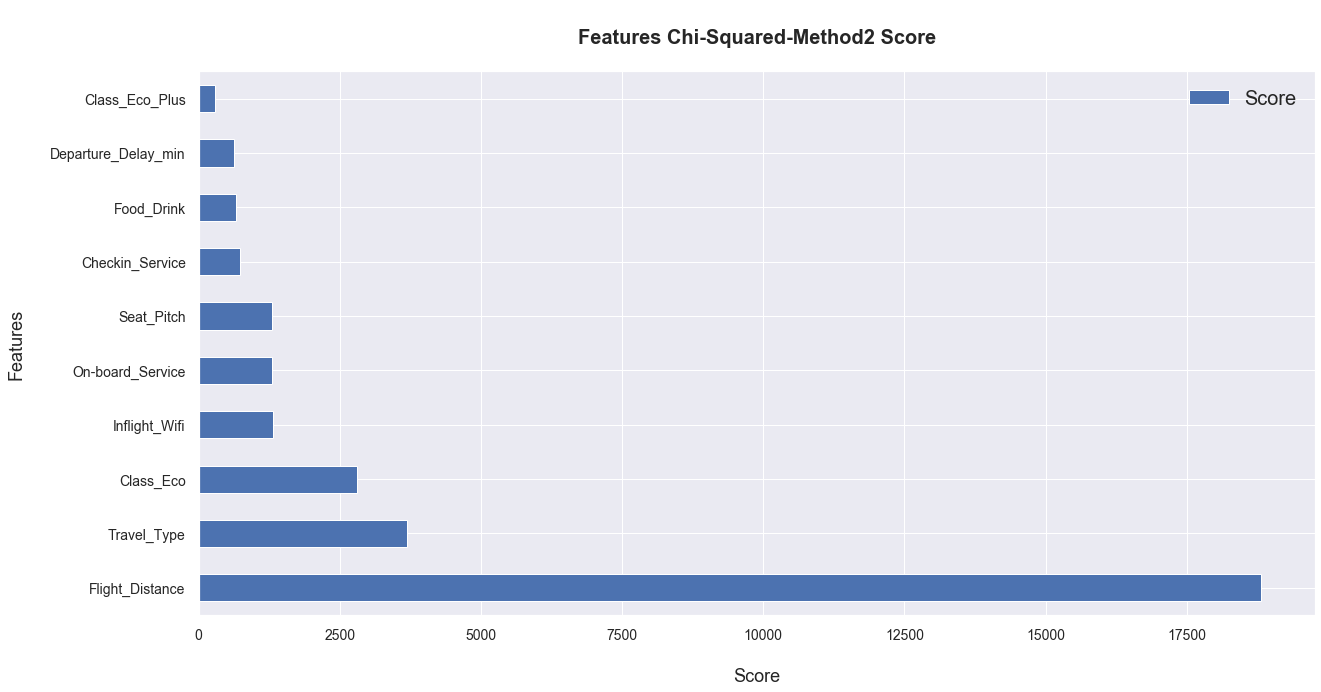

In [83]:
featscoreplot(fit3, 'Chi-Squared-Method2', numcla)
plt.savefig(f'img.png', bbox_inches='tight');

#### PCA (F-Classification DF) - Dimensionality Reduction for left-out features

In [84]:
pca_col=numcla.drop(featselecDF(fit1, numcla).columns.to_list(), axis=1)

In [85]:
pca_col.columns.to_list()

['Gender',
 'Customer_Type',
 'Age',
 'Departure_Arrival_Time_Convenience',
 'Gate_Location',
 'Food_Drink',
 'Departure_Delay_min',
 'Class_Eco_Plus']

In [86]:
pca=PCA(0.9)
pca_df=pd.DataFrame(pca.fit_transform(pca_col))

In [87]:
pca_df

,0,1,2,3
0,3.615323,-1.486995,1.071071,0.243577
1,-1.415006,2.853700,0.136927,-1.701866
2,-1.363270,2.143087,-2.003440,1.077842
3,-1.387644,2.989056,0.710171,0.366741
4,-1.398490,-0.063062,1.013379,-0.678631
...,...,...,...,...
25854,-1.403219,1.245504,-0.368686,-0.757953
25855,-1.389149,-1.175262,-1.699783,-0.975732
25856,-1.364434,-2.538049,-2.647747,0.898484
25857,-1.391644,0.297227,-2.434718,-1.014595


In [88]:
(pca.explained_variance_ratio_)[0:4]

array([0.57111502, 0.14969792, 0.11591794, 0.08888192])

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  This is separate from the ipykernel package so we can avoid doing imports until


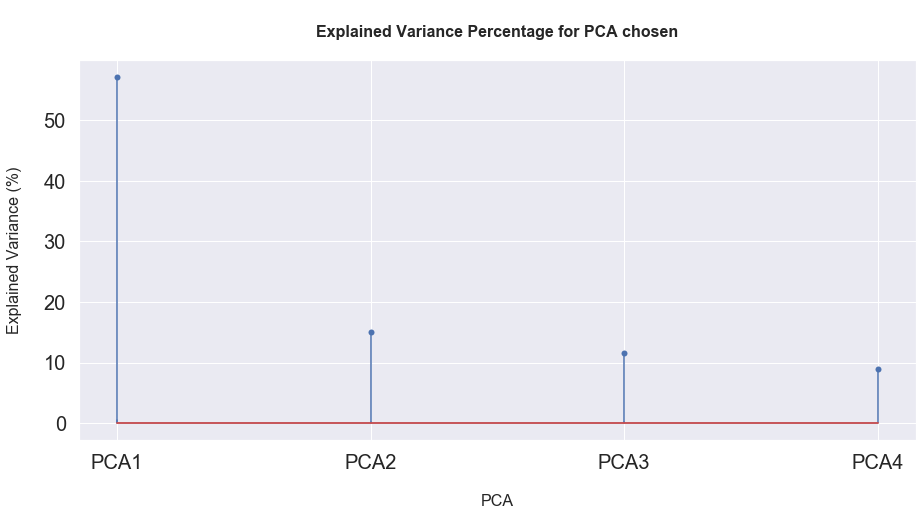

In [89]:
plt.figure(figsize=(15,7))

plt.stem(pca.explained_variance_ratio_, markerfmt=' ')
(markers, stemlines, baseline) = plt.stem(['PCA1', 'PCA2','PCA3', 'PCA4'],( pca.explained_variance_ratio_)*100, 
                                          use_line_collection=True);

plt.title(f'\nExplained Variance Percentage for PCA chosen\n', fontweight='bold', size=16)
plt.xlabel(f'\nPCA', size=16)
plt.ylabel(f'Explained Variance (%)\n', size=16)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14);

#### Clustering

In [117]:
kmeans = KMeans(3)

In [118]:
kmeans.fit(pca_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [119]:
y_km=kmeans.predict(pca_df)

In [93]:
# Same values if I've take the chi2 feature selection
(pd.DataFrame(y_km))[0].value_counts()

1    22613
0     2779
2      467
Name: 0, dtype: int64

In [94]:
print('KMODES Model Silhouette is',silhouette_score(pca_df,y_km))
print('KMODES Model Davies-Bouldin is',davies_bouldin_score(pca_df,y_km))

KMODES Model Silhouette is 0.4544412557119651
KMODES Model Davies-Bouldin is 0.9185870073763779


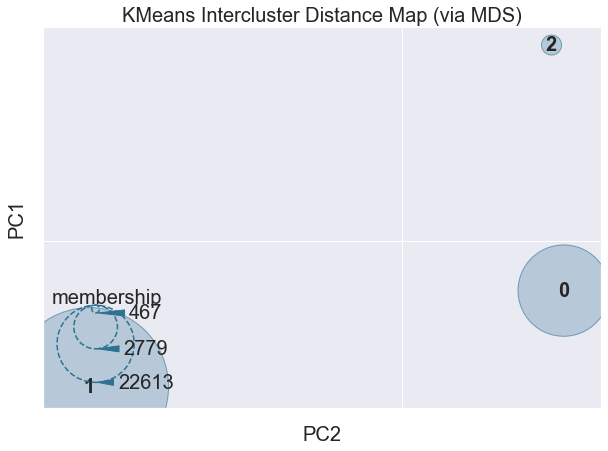

In [95]:
# InterCluster Distance Plot
plt.figure(figsize=(10,7))
viz=InterclusterDistance(kmeans)
viz.fit(pca_df)
#plt.xlabel(f'\nPC2', size=16)
#plt.ylabel(f'PC1\n', size=16);
#plt.title('\nKMeans Intercluster Distance Map\n')
viz.show();

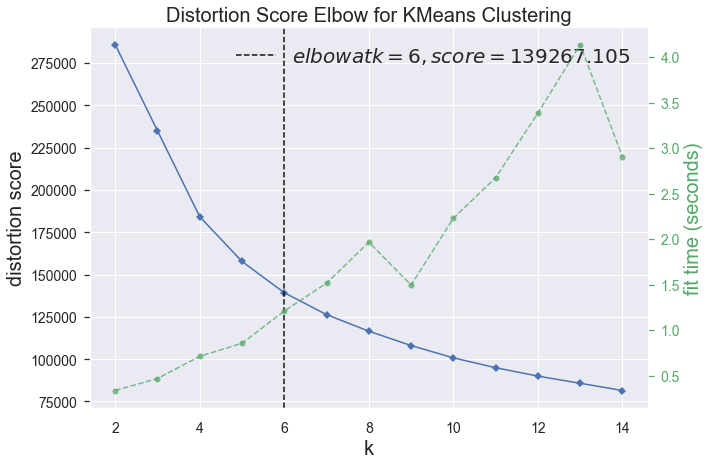

In [96]:
# Elbow Plot
plt.figure(figsize=(10,7))
visualizer = KElbowVisualizer(kmeans, k=(2,15))
visualizer.fit(pca_df)
visualizer.show();

In [97]:
(pd.DataFrame(y_km))[0].value_counts()

1    22613
0     2779
2      467
Name: 0, dtype: int64

Text(0, 0.5, 'Frequency\n')

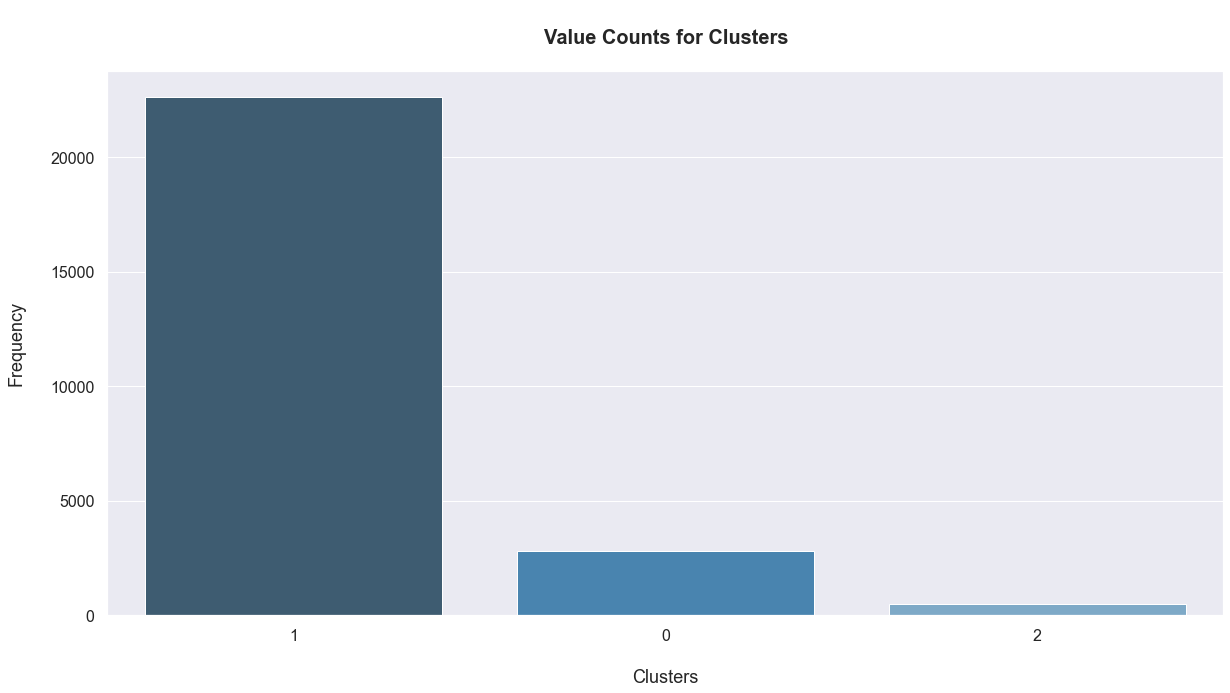

In [98]:
# Cluster Frequency Plots
plt.figure(figsize=(20,10))

sns.barplot(x=(pd.DataFrame(y_km))[0].value_counts().index.to_list(),y=(pd.DataFrame(y_km))[0].value_counts(), 
            palette="Blues_d", order=(pd.DataFrame(y_km))[0].value_counts().index.to_list())
plt.title('\nValue Counts for Clusters\n', fontweight='bold', fontsize=20)
plt.xticks(fontsize= 16)
plt.yticks(fontsize= 16)
plt.xlabel(f'\nClusters', size=18)
plt.ylabel(f'Frequency\n', size=18)

In [120]:
numcla_fe=featselecDF(fit1, numcla)

In [121]:
# Adding Cluster column to Feature Engineering Numcla DF
numcla_fe = pd.concat([numcla_fe,pd.DataFrame(y_km)],axis=1)
numcla_fe.rename(columns={0:'Clusters'}, inplace=True)

In [122]:
numcla_fe

,Travel_Type,Flight_Distance,Inflight_Wifi,On-board_Service,Seat_Pitch,Checkin_Service,Class_Eco,Clusters
0,0,1.60,5,5,5,2,1,0
1,0,28.63,1,4,4,3,0,1
2,0,1.92,2,4,1,2,1,1
3,0,33.77,0,1,1,3,0,1
4,0,11.82,2,2,2,4,1,1
...,...,...,...,...,...,...,...,...
25854,0,5.26,3,3,2,4,0,1
25855,0,6.46,4,4,5,5,0,1
25856,1,8.28,2,4,3,5,1,1
25857,0,11.27,3,3,2,4,0,1


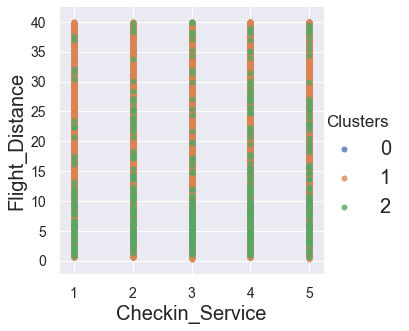

In [123]:
sns.lmplot(data=numcla_fe, y='Flight_Distance',x='Checkin_Service', hue='Clusters', fit_reg=False);

Plotting Cluster Correlations

In [124]:
pca_col.columns.to_list()

['Gender',
 'Customer_Type',
 'Age',
 'Departure_Arrival_Time_Convenience',
 'Gate_Location',
 'Food_Drink',
 'Departure_Delay_min',
 'Class_Eco_Plus']

Text(0.5, 1, 'Correlation between Check-in Service and Clusters\n')

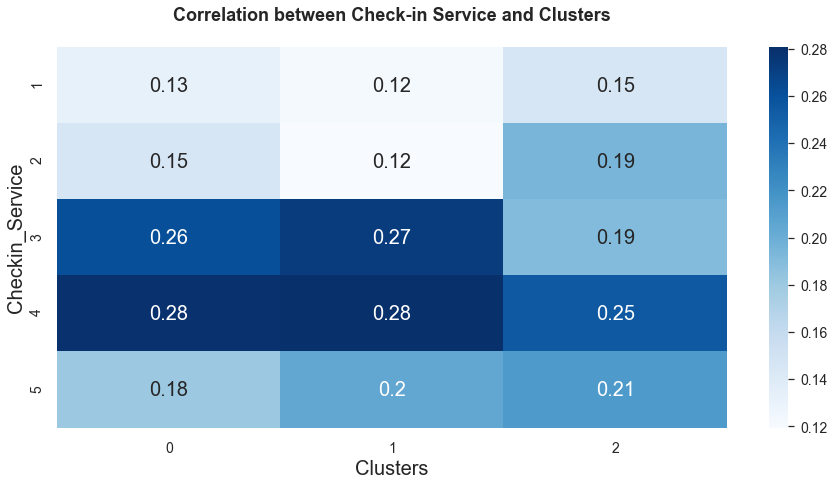

In [125]:
plt.figure(figsize=(15,7))
sns.heatmap(pd.crosstab(numcla.Checkin_Service, numcla_fe.Clusters, normalize='columns'), annot=True, cmap="Blues")
plt.title('Correlation between Check-in Service and Clusters\n', fontweight='bold', fontsize=18)

In [126]:
pd.crosstab(numcla_fe.Seat_Pitch, numcla_fe.Clusters, normalize='columns')

Clusters,0,1,2
Seat_Pitch,,,
0,0.003239,0.005174,0.000000
1,0.101475,0.098218,0.066381
2,0.198992,0.194578,0.092077
3,0.189637,0.189979,0.229122
4,0.283555,0.269403,0.387580
5,0.223102,0.242648,0.224839


PCA Clusters

In [127]:
centers = np.array(kmeans.cluster_centers_)

In [128]:
pca_df['Clusters']=y_km

In [129]:
pca_df.rename(columns={0:'P1', 1:'P2', 2:'P3'}, inplace=True)

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:574: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


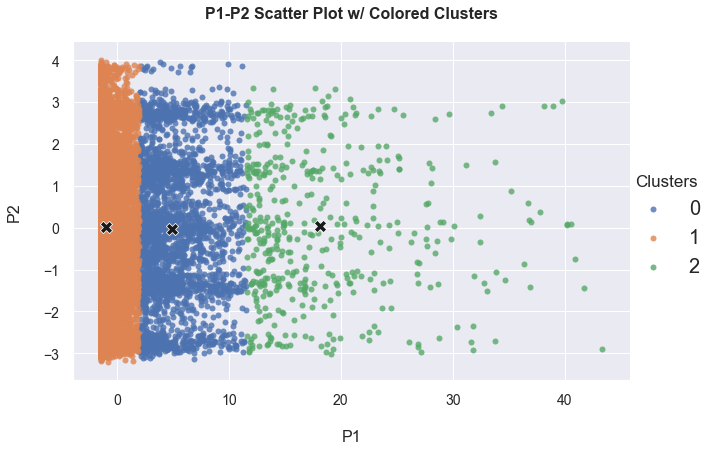

In [130]:
sns.lmplot(data=pca_df, x='P1', y='P2', hue='Clusters', fit_reg=False, aspect=1.5, size=(6))
sns.scatterplot(centers[:,0], centers[:,1], marker="X", color='k', s=150, legend=False)
plt.title(f'P1-P2 Scatter Plot w/ Colored Clusters\n', fontweight='bold', fontsize=16)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
plt.xlabel(f'\nP1', size=16)
plt.ylabel(f'P2\n', size=16);

### Modeling
Cross Validation and Hyper-Parameter Tuning

In [110]:
y_mod=aps['Churn'].astype(int)

In [111]:
numcla_fe

,Travel_Type,Flight_Distance,Inflight_Wifi,On-board_Service,Seat_Pitch,Checkin_Service,Class_Eco,Clusters
0,0,1.60,5,5,5,2,1,0
1,0,28.63,1,4,4,3,0,1
2,0,1.92,2,4,1,2,1,1
3,0,33.77,0,1,1,3,0,1
4,0,11.82,2,2,2,4,1,1
...,...,...,...,...,...,...,...,...
25854,0,5.26,3,3,2,4,0,1
25855,0,6.46,4,4,5,5,0,1
25856,1,8.28,2,4,3,5,1,1
25857,0,11.27,3,3,2,4,0,1


In [112]:
X_train_n,X_test_n,y_train_n,y_test_n=train_test_split(numcla_fe, 
                                               y_mod,
                                               test_size=0.3,
                                               random_state=42,
                                               stratify=y_mod)

In [113]:
catcla

,Gender,Customer_Type,Age,Travel_Type,Class,Flight_Distance,Inflight_Wifi,Departure_Arrival_Time_Convenience,Ease_of_Online_Booking,Gate_Location,Food_Drink,Online_Boarding,Seat_Comfort,Inflight_Entertainment,On-board_Service,Seat_Pitch,Baggage_Handling,Checkin_Service,Inflight_Service,Cleanliness,Departure_Delay_min,Arrival_Delay_min
0,0,1,5.2,0,0,1.60,5,4,3,4,3,4,3,5,5,5,5,2,5,5,5.0,4.4
1,0,1,3.6,0,2,28.63,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0.0,0.0
2,1,0,2.0,0,0,1.92,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0.0,0.0
3,1,1,4.4,0,2,33.77,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0.0,0.6
4,0,1,4.9,0,0,11.82,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25854,1,0,3.4,0,2,5.26,3,3,3,1,4,3,4,4,3,2,4,4,5,4,0.0,0.0
25855,1,1,2.3,0,2,6.46,4,4,4,4,4,4,4,4,4,5,5,5,5,4,0.0,0.0
25856,0,1,1.7,1,0,8.28,2,5,1,5,2,1,2,2,4,3,4,5,4,2,0.0,0.0
25857,1,1,1.4,0,2,11.27,3,3,3,3,4,4,4,4,3,2,5,4,5,4,0.0,0.0


In [114]:
X_train_c, X_test_c, y_train_c, y_test_c=train_test_split(catcla, 
                                               y_mod,
                                               test_size=0.3,
                                               random_state=42,
                                               stratify=y_mod)

In [115]:
y_mod.value_counts()

0    14509
1    11350
Name: Churn, dtype: int64

In [116]:
def modresult(x,y,xt,yt,mod):
    #mod=grid_search.fit(x,y)
    r1=mod.best_score_
    r2=mod.best_estimator_
    ypred=mod.predict(xt)
    r3=confusion_matrix(yt,ypred)
    r4=round(metrics.accuracy_score(yt, ypred),3)
    r5=round(metrics.recall_score(yt, ypred),3)
    r6=round(metrics.precision_score(yt, ypred),3)
    r7=round(metrics.f1_score(yt, ypred),3)
    r8=round(metrics.roc_auc_score(yt, ypred, average='macro'),3)
    return print(f'MODEL BEST SCORE: {round(r1,3)}\n\nMODEL BEST ESTIMATOR: {r2}\n\nCONFUSION MATRIX:\n{r3}\n\nACCURACY: {r4}\n\nRECALL: {r5}\n\nPRECISION: {r6}\n\nF1-SCORE: {r7}\n\nROC: {r8}\n\nClASSIFICATION REPORT: \n{classification_report(yt, ypred)}')
    
    

In [131]:
def featimp(mod,xt, modname):
    importances = ((mod.best_estimator_.feature_importances_)*100).round(2)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")
    for f in range(xt.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure(figsize=(15,7))
    plt.title("Feature importances")
    plt.barh(range(xt.shape[1]), importances[indices], color="b", align="center")
    plt.yticks(range(xt.shape[1]), xt.columns[indices], size=12)
    plt.ylim([-1, xt.shape[1]])
    plt.ylabel('Features\n', size=16)
    plt.xticks(size=12)
    plt.xlabel('\nPercentage Importance', size=16)
    plt.title(f'\n{modname} Feature Importance\n', fontweight='bold', size=18)
    #plt.savefig(f'img.png', bbox_inches='tight');
    return plt.show()

KNN

In [132]:
model_KN=KNeighborsClassifier()

params={'n_neighbors':range(1,22,2), 
        'weights':['uniform','distance'], 
        'metric':['euclidian','manhattan','minkowski']}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

grid_search=GridSearchCV(estimator=model_KN, param_grid=params, n_jobs=-1, scoring='recall', cv=cv)

In [133]:
kn_mod=grid_search.fit(X_train_n,y_train_n)

In [134]:
modresult(X_train_n,y_train_n,X_test_n,y_test_n,kn_mod)

MODEL BEST SCORE: 0.845

MODEL BEST ESTIMATOR: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

CONFUSION MATRIX:
[[3867  486]
 [ 515 2890]]

ACCURACY: 0.871

RECALL: 0.849

PRECISION: 0.856

F1-SCORE: 0.852

ROC: 0.869

ClASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       0.88      0.89      0.89      4353
           1       0.86      0.85      0.85      3405

    accuracy                           0.87      7758
   macro avg       0.87      0.87      0.87      7758
weighted avg       0.87      0.87      0.87      7758



Logistic Regression 

In [135]:
# Doesn't need hyper-parameter tunning - As for the probability threshhold, it isnt considered as Hyper-Parameter Tunning
# since no change in the model function (you are just changing the threshhold)
thresholds=np.linspace(0,1,100)
dct={}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

model_LR=LogisticRegressionCV(cv=cv, max_iter=10000, class_weight='balanced')
lr_mod=model_LR.fit(X_train_n, y_train_n)
y_pred={i:(lr_mod.predict_proba(X_test_n)[:,1]>i).astype(int) for i in thresholds}

for x,y in y_pred.items():
    conf=confusion_matrix(y_test_n, y)
    ac=round(accuracy_score(y_test_n, y),3)
    if (conf[0][1]==0) & (conf[1][1]==0):
        prec=0
    else:
        prec=round(metrics.precision_score(y_test_n,y),3)
    rec=round(metrics.recall_score(y_test_n,y),3)
    f1=round(metrics.f1_score(y_test_n,y),3)
    roc=round(metrics.roc_auc_score(y_test_n,y),3)
    dct[round(x,3)]=(ac,prec,rec,f1,roc)

print('\nLINEAR REGRESSION:\n','\n Optimal Threshold, Accuracy, Precision, Recall, F1-Score, Roc: ',max(dct.items(), key = lambda x: x[1]))


LINEAR REGRESSION:
 
 Optimal Threshold, Accuracy, Precision, Recall, F1-Score, Roc:  (0.606, (0.82, 0.816, 0.76, 0.787, 0.813))


Random Forest Classifier

In [136]:
model_RF=RandomForestClassifier()

params={'n_estimators':[10,100],
'criterion':['gini','entropy'],
'max_depth':[None,5],
'bootstrap':[True, False],
'warm_start':[False,True],
'class_weight':[None,'balanced','balanced_subsample']}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

grid_search=GridSearchCV(estimator=model_RF, param_grid=params, n_jobs=-1, scoring='recall', cv=cv)

In [137]:
rf_mod=grid_search.fit(X_train_c,y_train_c)

In [138]:
modresult(X_train_c,y_train_c,X_test_c,y_test_c,rf_mod)

MODEL BEST SCORE: 0.936

MODEL BEST ESTIMATOR: RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

CONFUSION MATRIX:
[[4212  141]
 [ 208 3197]]

ACCURACY: 0.955

RECALL: 0.939

PRECISION: 0.958

F1-SCORE: 0.948

ROC: 0.953

ClASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      4353
           1       0.96      0.94      0.95      3405

    accuracy                           0.96      7758
   macro avg       0.96      0.

Feature ranking:
1. feature 11 (16.090000)
2. feature 6 (14.370000)
3. feature 4 (10.310000)
4. feature 3 (10.290000)
5. feature 13 (6.330000)
6. feature 8 (4.090000)
7. feature 12 (3.860000)
8. feature 1 (3.710000)
9. feature 15 (3.580000)
10. feature 5 (3.480000)
11. feature 2 (3.320000)
12. feature 19 (2.880000)
13. feature 17 (2.660000)
14. feature 14 (2.520000)
15. feature 16 (2.340000)
16. feature 18 (2.230000)
17. feature 7 (1.810000)
18. feature 9 (1.800000)
19. feature 21 (1.310000)
20. feature 20 (1.260000)
21. feature 10 (1.250000)
22. feature 0 (0.520000)


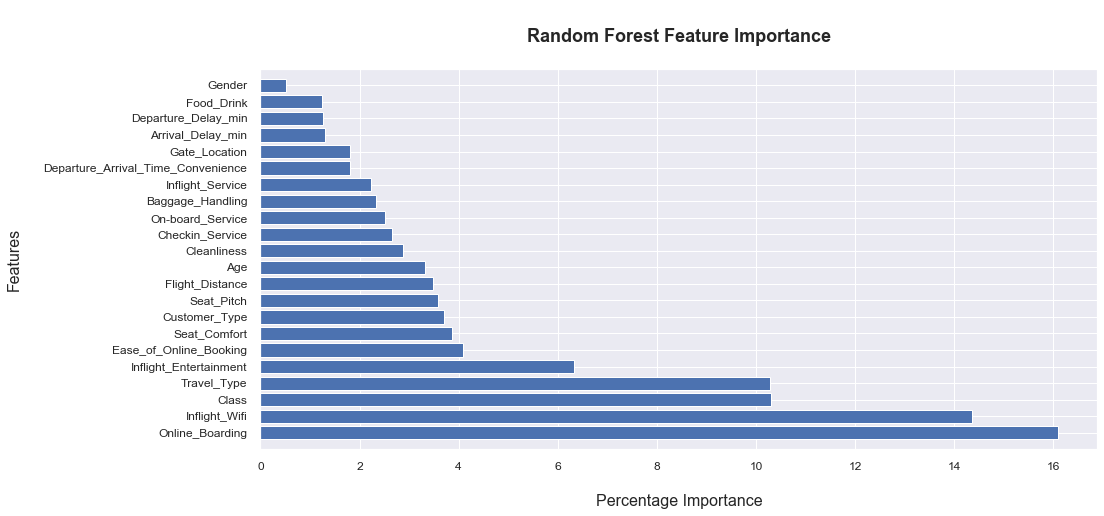

In [139]:
# Plotting Feature Importance
featimp(rf_mod,X_test_c, 'Random Forest')

XGBoost

In [140]:
model_XGB=xgb.XGBClassifier()

params={'n_estimators':[10,100],
'criterion':['friedman_mse', 'mse', 'mae'],
'max_depth':[None,5],
'max_features':['auto', 'sqrt', 'log2'],
'warm_start':[False,True]}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

grid_search=GridSearchCV(estimator=model_XGB, param_grid=params, n_jobs=-1, scoring='recall', cv=cv)

In [141]:
xgb_mod=grid_search.fit(X_train_c,y_train_c)

In [142]:
modresult(X_train_c,y_train_c,X_test_c,y_test_c,xgb_mod)

MODEL BEST SCORE: 0.934

MODEL BEST ESTIMATOR: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, criterion='friedman_mse',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
              max_features='auto', min_child_weight=1, missing=None,
              n_estimators=100, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1, warm_start=False)

CONFUSION MATRIX:
[[4205  148]
 [ 219 3186]]

ACCURACY: 0.953

RECALL: 0.936

PRECISION: 0.956

F1-SCORE: 0.946

ROC: 0.951

ClASSIFICATION REPORT: 
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      4353
           1       0.96      0.94      0.95      3405

    accuracy                           0.95      7758
   macro avg       0.95      0.95   

Feature ranking:
1. feature 11 (36.980000)
2. feature 3 (12.400000)
3. feature 6 (6.930000)
4. feature 17 (5.650000)
5. feature 4 (5.010000)
6. feature 1 (4.470000)
7. feature 13 (3.780000)
8. feature 18 (3.490000)
9. feature 19 (3.080000)
10. feature 16 (2.960000)
11. feature 15 (2.940000)
12. feature 14 (2.910000)
13. feature 12 (2.550000)
14. feature 9 (2.090000)
15. feature 7 (1.060000)
16. feature 21 (0.960000)
17. feature 2 (0.770000)
18. feature 5 (0.620000)
19. feature 10 (0.480000)
20. feature 8 (0.430000)
21. feature 20 (0.320000)
22. feature 0 (0.090000)


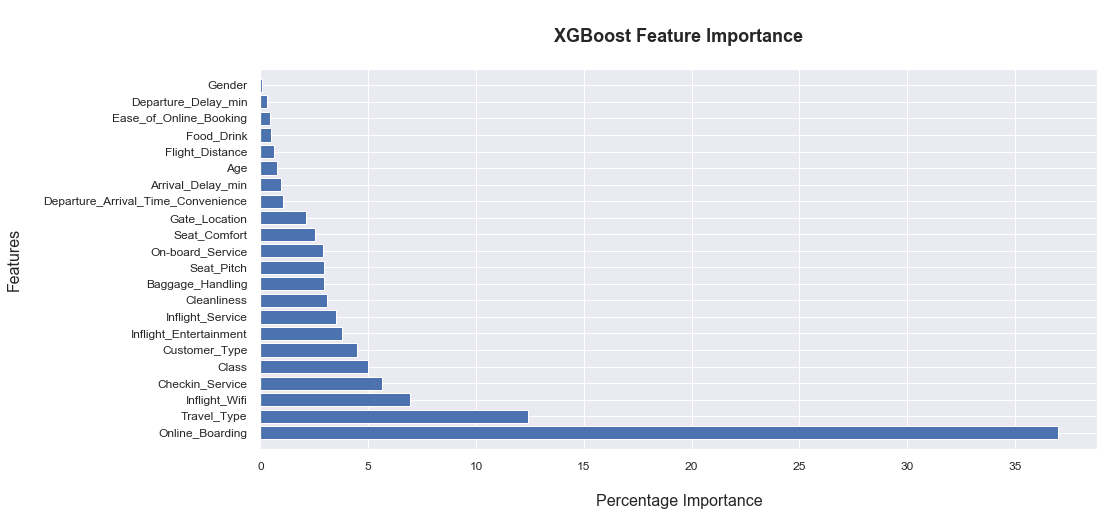

In [143]:
# Plottimng Feature Importance
featimp(xgb_mod,X_test_c, 'XGBoost')

Cumalative ROC Curve for Models

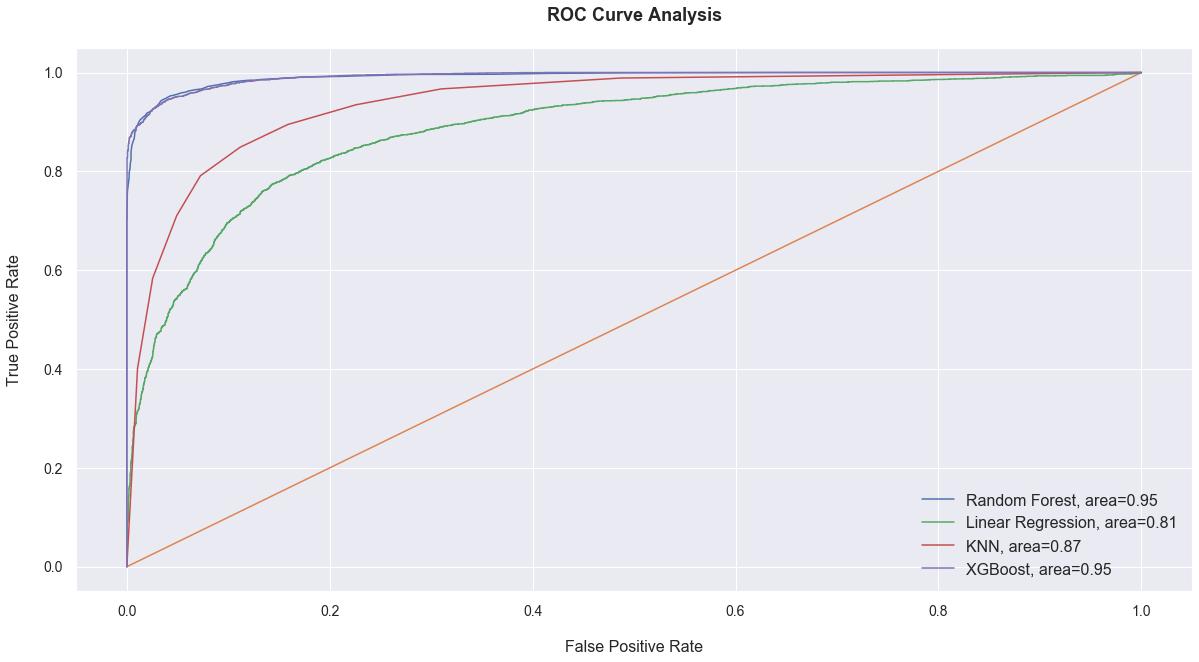

In [144]:
model_roc=roc_auc_score(y_test_c, rf_mod.predict(X_test_c))
fpr,tpr,thresholds=roc_curve(y_test_c, rf_mod.predict_proba(X_test_c)[:,1])
plt.figure(figsize=(20,10))
plt.plot(fpr,tpr, label=f'Random Forest, area={model_roc.round(2)}')
plt.plot([0,1],[0,1])

model_roc2=roc_auc_score(y_test_n, lr_mod.predict(X_test_n))
fpr,tpr,thresholds=roc_curve(y_test_n, lr_mod.predict_proba(X_test_n)[:,1])
plt.plot(fpr,tpr, label=f'Linear Regression, area={model_roc2.round(2)}')

model_roc3=roc_auc_score(y_test_n, kn_mod.predict(X_test_n))
fpr,tpr,thresholds=roc_curve(y_test_n, kn_mod.predict_proba(X_test_n)[:,1])
plt.plot(fpr,tpr, label=f'KNN, area={model_roc3.round(2)}')

model_roc4=roc_auc_score(y_test_c, xgb_mod.predict(X_test_c))
fpr,tpr,thresholds=roc_curve(y_test_c, xgb_mod.predict_proba(X_test_c)[:,1])
plt.plot(fpr,tpr, label=f'XGBoost, area={model_roc4.round(2)}')

plt.title('ROC Curve Analysis\n', fontweight='bold', fontsize=18)
plt.legend(loc=4, prop={'size': 16})
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
plt.xlabel(f'\nFalse Positive Rate', size=16)
plt.ylabel(f'True Positive Rate\n', size=16);
plt.show()


#### PYCARET
Low Code Machine Learning Library

In [145]:
from pycaret.classification import *

In [146]:
# Importing a module prepares an environment for specific task
# For example, if you have imported the Classification module, the environment will be setup accordingly to perform classification tasks only
clf=aps.copy()
dct={'Business':0, 'Eco':1, 'Eco_Plus':2}
clf.Class=clf.Class.map(dct)

In [147]:
pycaret_df=setup(data=clf, target='Churn', session_id=123)

 
Setup Succesfully Completed!


,Description,Value
0,session_id,123
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(25859, 23)"
4,Missing Values,False
5,Numeric Features,4
6,Categorical Features,18
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [148]:
# number of folds=10 (Default)
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Light Gradient Boosting Machine,0.958600,0.993400,0.938200,0.966400,0.952100,0.915600
1,CatBoost Classifier,0.957500,0.993600,0.941300,0.961000,0.951000,0.913400
2,Extra Trees Classifier,0.954800,0.991300,0.933300,0.962700,0.947700,0.907900
3,Gradient Boosting Classifier,0.942800,0.987700,0.921300,0.946900,0.933900,0.883500
4,Random Forest Classifier,0.941700,0.984500,0.905200,0.959600,0.931600,0.880800
5,Extreme Gradient Boosting,0.941100,0.987600,0.917700,0.946500,0.931800,0.879900
6,Decision Tree Classifier,0.935500,0.934500,0.926200,0.926800,0.926500,0.869000
7,Logistic Regression,0.931600,0.978400,0.913300,0.929700,0.921300,0.860800
8,Ridge Classifier,0.928800,0.000000,0.907700,0.928700,0.918000,0.855200
9,Linear Discriminant Analysis,0.928800,0.975000,0.907700,0.928700,0.918000,0.855200


Random Forest

In [155]:
rf=create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9382,0.9836,0.8906,0.9659,0.9267,0.8734
1,0.9420,0.9824,0.9082,0.9576,0.9322,0.8816
2,0.9431,0.9866,0.9057,0.9626,0.9332,0.8837
3,0.9414,0.9851,0.9094,0.9551,0.9317,0.8805
4,0.9420,0.9864,0.9094,0.9563,0.9323,0.8816
5,0.9381,0.9840,0.9005,0.9559,0.9274,0.8736
6,0.9392,0.9843,0.9043,0.9548,0.9288,0.8759
7,0.9425,0.9830,0.8980,0.9688,0.9320,0.8824
8,0.9420,0.9831,0.9030,0.9624,0.9318,0.8814
9,0.9481,0.9868,0.9232,0.9569,0.9397,0.8941


##### plot_model(rf, plot='feature')
#plt.xticks(fontsize= 14)
#plt.yticks(fontsize= 14);
#plt.xlabel(f'\nVariable Importance', size=16)
#plt.ylabel(f'Features\n', size=16)
#plt.title('\nFeature Importance Plot\n')
#plt.savefig(f'img1.png', bbox_inches='tight');

In [ ]:
plot_model(rf, plot='confusion_matrix')

Logistic Regression

In [ ]:
rf2=create_model('lr')
plot_model(rf2, plot='confusion_matrix')